---
# Final Analyses

After `dn_compare.ipynb`, this notebook includes some of the final figures

In [1]:
from linescanning import (
    utils,
    plotting,
    fitting,
    glm
)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import pickle
import holeresponse as hr
import nibabel as nb
import seaborn as sns
from scipy import stats
opj = os.path.join
opd = os.path.dirname

## Read Data

In [165]:
# import subject dictionary containing useful information
include_subjs = ["001","002","005","006","008","010","011","013","014","015","022"]
subj_obj = hr.utils.SubjectsDict(proj_dir="/data1/projects/MicroFunc/Jurjen/projects/VE-NORDIC")
subj_obj.proj_dir

'/data1/projects/MicroFunc/Jurjen/projects/VE-NORDIC'

In [166]:
pkl_files = []

objs = {}
data_dir = opj(os.path.dirname(hr.viz._save_figure(None, return_figdir=True)), "data")
h5_pkl = opj(data_dir, "dn_full_sample_voxel_correction2.pkl")
print(f"pkl file: '{h5_pkl}'")
with open(h5_pkl, 'rb') as handle:
    h5_obj = pickle.load(handle)

pkl file: '/data1/projects/MicroFunc/Jurjen/programs/project_repos/holeresponse/data/dn_full_sample_voxel_correction2.pkl'


In [167]:
# get h5-file
deriv = subj_obj.deriv_dir

h5_files = []
for i in include_subjs:
    sub = f"sub-{i}"
    ses = subj_obj.get_session(sub)
    h5 = utils.FindFiles(opj(subj_obj.deriv_dir, "lsprep", sub), extension="h5").files

    if len(h5)>0:
        h5_filt = utils.get_file_from_substring([f"ses-{ses}","desc-0p"], h5)
        h5_files.append(h5_filt)

h5_files

['/data1/projects/MicroFunc/Jurjen/projects/VE-NORDIC/derivatives/lsprep/sub-001/sub-001_ses-4_desc-0p_bold.h5',
 '/data1/projects/MicroFunc/Jurjen/projects/VE-NORDIC/derivatives/lsprep/sub-002/sub-002_ses-3_desc-0p_bold.h5',
 '/data1/projects/MicroFunc/Jurjen/projects/VE-NORDIC/derivatives/lsprep/sub-005/sub-005_ses-2_desc-0p_bold.h5',
 '/data1/projects/MicroFunc/Jurjen/projects/VE-NORDIC/derivatives/lsprep/sub-006/sub-006_ses-3_desc-0p_bold.h5',
 '/data1/projects/MicroFunc/Jurjen/projects/VE-NORDIC/derivatives/lsprep/sub-008/sub-008_ses-3_desc-0p_bold.h5',
 '/data1/projects/MicroFunc/Jurjen/projects/VE-NORDIC/derivatives/lsprep/sub-010/sub-010_ses-4_desc-0p_bold.h5',
 '/data1/projects/MicroFunc/Jurjen/projects/VE-NORDIC/derivatives/lsprep/sub-011/sub-011_ses-2_desc-0p_bold.h5',
 '/data1/projects/MicroFunc/Jurjen/projects/VE-NORDIC/derivatives/lsprep/sub-013/sub-013_ses-2_desc-0p_bold.h5',
 '/data1/projects/MicroFunc/Jurjen/projects/VE-NORDIC/derivatives/lsprep/sub-014/sub-014_ses-2_d

## Epoch data

In [168]:
# sub_df | average ribbon
sub_ep = fitting.Epoch(
    h5_obj.df_avg.groupby(["subject","task","t"]).mean(),
    hr.data.average_tasks(h5_obj.df_onsets),
    TR=0.105,
    interval=[-2,14]
)
sub_df = sub_ep.df_epoch.copy()

In [169]:
# comp_df | depth epochs
comp_ep = fitting.Epoch(
    h5_obj.df_comps.groupby(["subject","task","t"]).mean(),
    hr.data.average_tasks(h5_obj.df_onsets),
    TR=0.105,
    interval=[-2,14]
)
comp_df = comp_ep.df_epoch.copy()

In [170]:
# line_df | full line epochs
line_ep = fitting.Epoch(
    h5_obj.df_func.groupby(["subject","task","t"]).mean(),
    hr.data.average_tasks(h5_obj.df_onsets),
    TR=0.105,
    interval=[-2,14]
)
line_df = line_ep.df_epoch.copy()

## Plots

### New stimulus config + profile

Writing '/data1/projects/MicroFunc/Jurjen/programs/project_repos/holeresponse/images/group_desc-composite_stims5.pdf'
Writing '/data1/projects/MicroFunc/Jurjen/programs/project_repos/holeresponse/images/group_desc-composite_stims5.png'
Writing '/data1/projects/MicroFunc/Jurjen/programs/project_repos/holeresponse/images/group_desc-composite_stims5.svg'


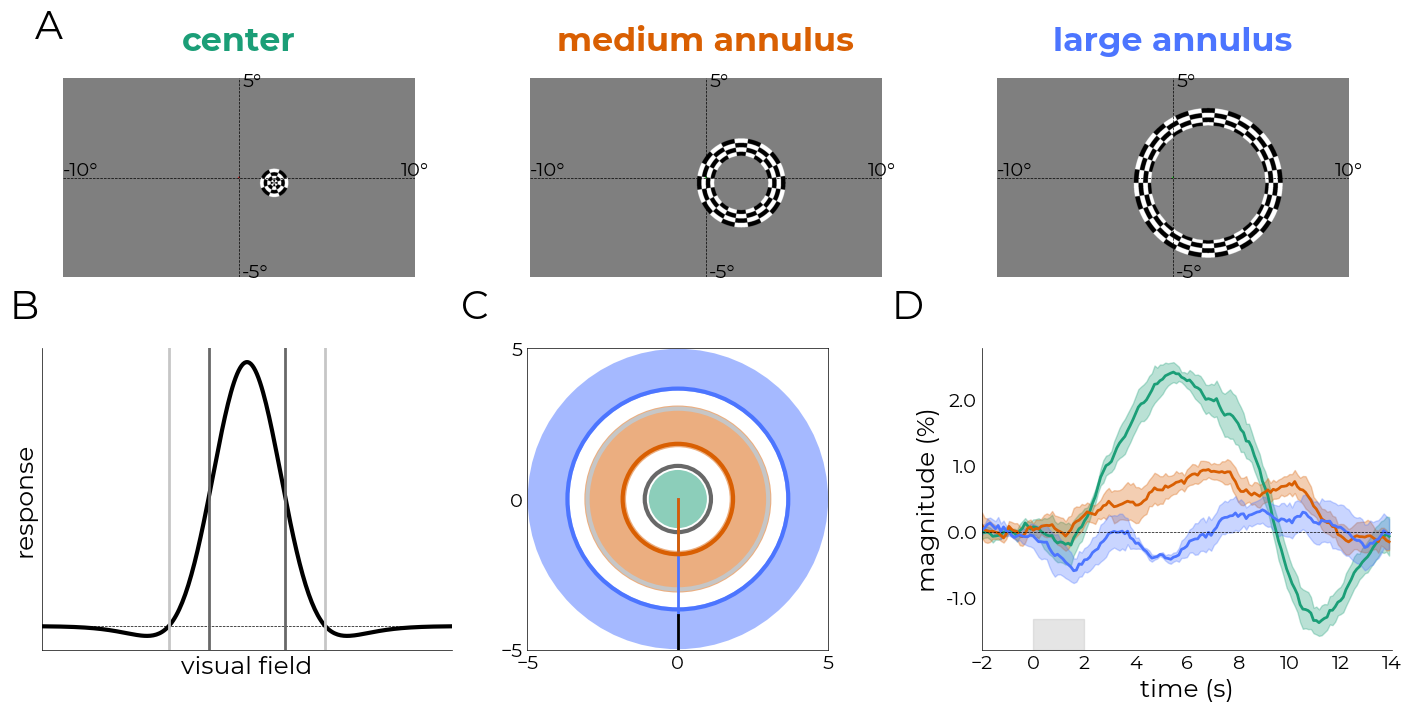

In [88]:
%matplotlib inline
ncols = 4
nrows = int(np.ceil(len(include_subjs)/ncols))

fig = plt.figure(figsize=(14,7), constrained_layout=True)
sfs = fig.subfigures(
    nrows=2, 
    height_ratios=[0.4,0.6], 
    hspace=0
)
sf1 = sfs[0].subplots(ncols=3)

ref_subj = "sub-013"
scr_obj = hr.viz.StimPNGs(ref_subj)
scr_obj.generate_screen_images(
    axs=sf1, 
    annotate=True
)

axs = sfs[1].subplots(
    ncols=3, 
    # gridspec_kw={"wspace": 0.15}
)

prof1d = hr.viz.StimPNGs.get_1d_profile(
    scr_obj.h_pars,
    n_pix=270
)

prof = prof1d.prof_1d.squeeze()
prof /= prof.max()
rf_cm = sns.color_palette("Greys_r", 2)
pl = plotting.LazyPlot(
    prof,
    line_width=3,
    color="k",
    axs=axs[0],
    add_hline=0,
    add_vline={
        "pos": prof1d.zero_cross_pix+[prof1d.metrics.iloc[0].fwhm_obj.t0_,prof1d.metrics.iloc[0].fwhm_obj.t1_],
        "color": [rf_cm[1],rf_cm[1],rf_cm[0],rf_cm[0]],
        "ls": "solid",
        "lw": 2
    },
    x_label="visual field",
    y_label="response",
    # y_lim=[0,prof.max()*1.1],
    x_ticks=[],
    y_ticks=[]
)

# stim dimensions
hr.viz.ExampleStims(
    axs=axs[1],
    fc=0.965,
    radii2=[1.9,3.8]
)

# example profile
sub = include_subjs[include_subjs.index(f"{ref_subj.split('-')[-1]}")]
select_sub = utils.select_from_df(sub_df, expression=f"subject = {sub}")
t_ = utils.get_unique_ids(select_sub, id="t")
sub_gm = utils.select_from_df(select_sub, expression="ribbon", indices=[0])
avg_epoch = hr.viz.PlotEpochProfiles(
    sub_gm.groupby(["subject","event_type", "epoch","t"]).mean(),
    axs=axs[-1],
    ev_names=["center","near","far"],
    cm=subj_obj.get_colors(),
    bsl=20,
    x_ticks=np.arange(t_[0],t_[-1]*1.1, step=2),
    y_dec=1,
    labels=None,
    # y_label=None,
    # x_label=None
)

plotting.fig_annot(
    fig,
    axs=[
        fig.axes[0],
        fig.axes[3],
        fig.axes[4],
        fig.axes[5]
    ],
    x0_corr=-0.25,
    x_corr=[-0.25,-0.7,-0.7],
    y=[1.2,1.1,1.1,1.1]
)

hr.viz._save_figure(
    fig, 
    fname="group_desc-composite_stims5", 
    overwrite=True
)

plotting 'sub-001'
plotting 'sub-002'
plotting 'sub-005'
plotting 'sub-006'
plotting 'sub-008'
plotting 'sub-010'
plotting 'sub-011'
plotting 'sub-013'
plotting 'sub-014'
plotting 'sub-015'
plotting 'sub-022'
Writing '/data1/projects/MicroFunc/Jurjen/programs/project_repos/holeresponse/images/group_desc-subject_stims.pdf'
Writing '/data1/projects/MicroFunc/Jurjen/programs/project_repos/holeresponse/images/group_desc-subject_stims.png'
Writing '/data1/projects/MicroFunc/Jurjen/programs/project_repos/holeresponse/images/group_desc-subject_stims.svg'


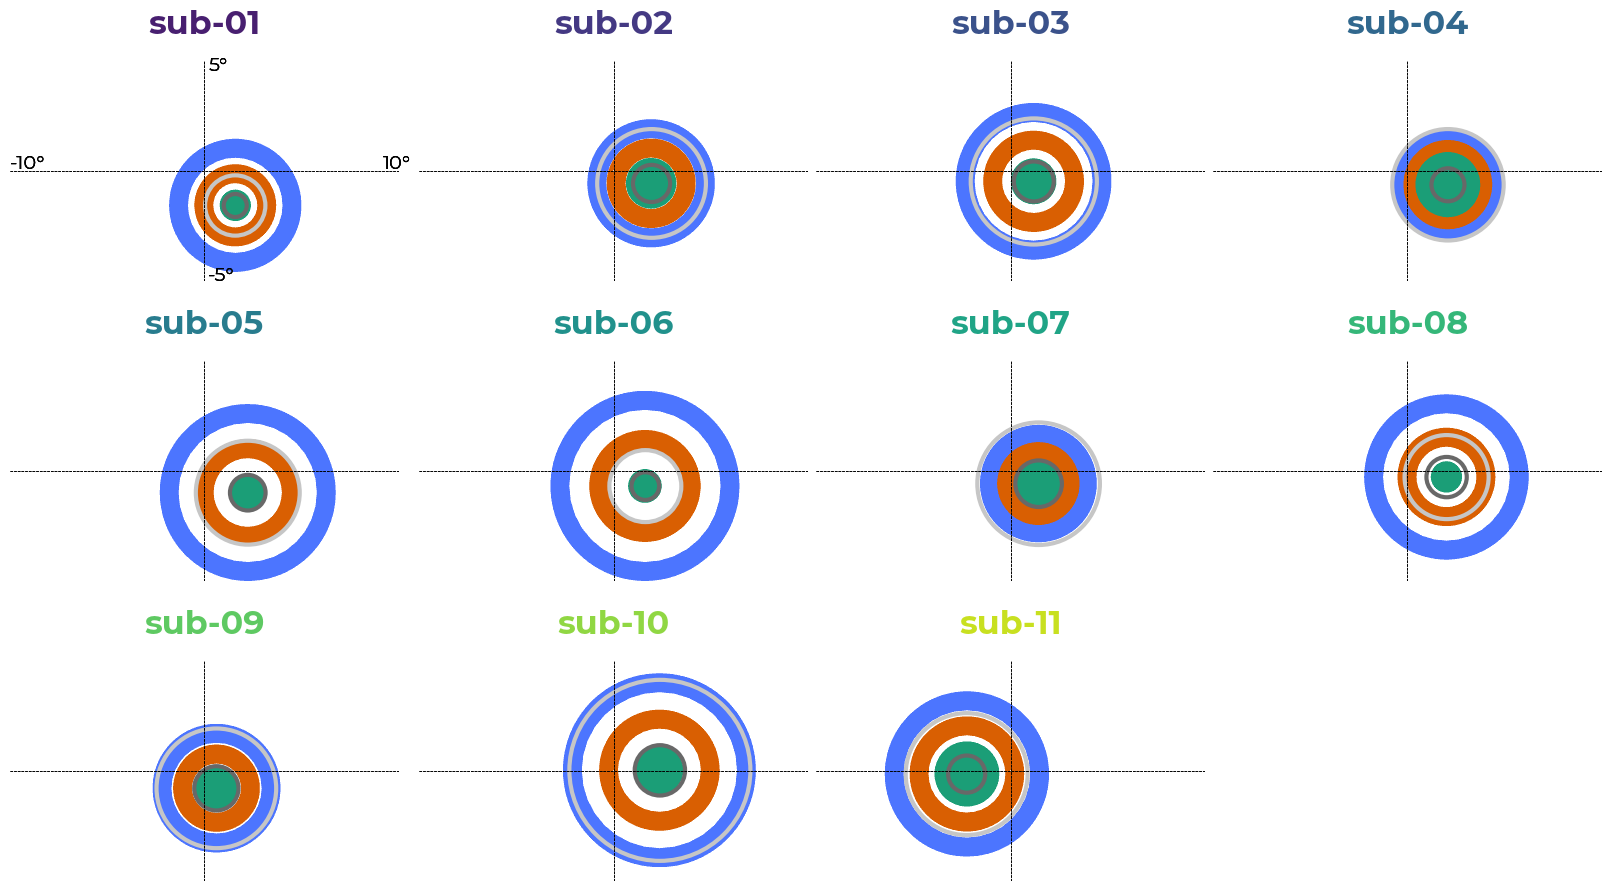

In [94]:
%matplotlib inline
ncols = 4
nrows = int(np.ceil(len(include_subjs)/ncols))

fig,axs = plt.subplots(
    figsize=(4*ncols,3*nrows), 
    ncols=ncols,
    nrows=nrows,
    constrained_layout=True
)

objs = {}
cm = sns.color_palette("viridis", len(include_subjs))
for ix,ax in enumerate(axs.flatten()):

    annot = False
    if ix == 0:
        annot = True

    if (ix+1)>len(include_subjs):
        # remove obsolete axes
        ax.remove()
    else:
        sub = f"sub-{include_subjs[ix]}"
        print(f"plotting '{sub}'")
        png_obj = hr.viz.StimPNGs(sub, n_pix=270)   
        png_obj.generate_composite(
            axs=ax, 
            annotate=annot, 
            title={
                "title": f"sub-{str(ix+1).zfill(2)}", 
                "fontweight": "bold",
                "color": cm[ix]
            },
            add_prf=True
        )

        objs[sub] = png_obj

hr.viz._save_figure(
    fig, 
    fname="group_desc-subject_stims", 
    overwrite=True
)

### Stimulus configurations (original)

plotting 'sub-001'
plotting 'sub-002'
plotting 'sub-005'
plotting 'sub-006'
plotting 'sub-008'
plotting 'sub-010'
plotting 'sub-011'
plotting 'sub-013'
plotting 'sub-014'
plotting 'sub-015'
plotting 'sub-022'
Writing '/data1/projects/MicroFunc/Jurjen/programs/project_repos/holeresponse/images/group_desc-composite_stims4.pdf'
Writing '/data1/projects/MicroFunc/Jurjen/programs/project_repos/holeresponse/images/group_desc-composite_stims4.png'
Writing '/data1/projects/MicroFunc/Jurjen/programs/project_repos/holeresponse/images/group_desc-composite_stims4.svg'


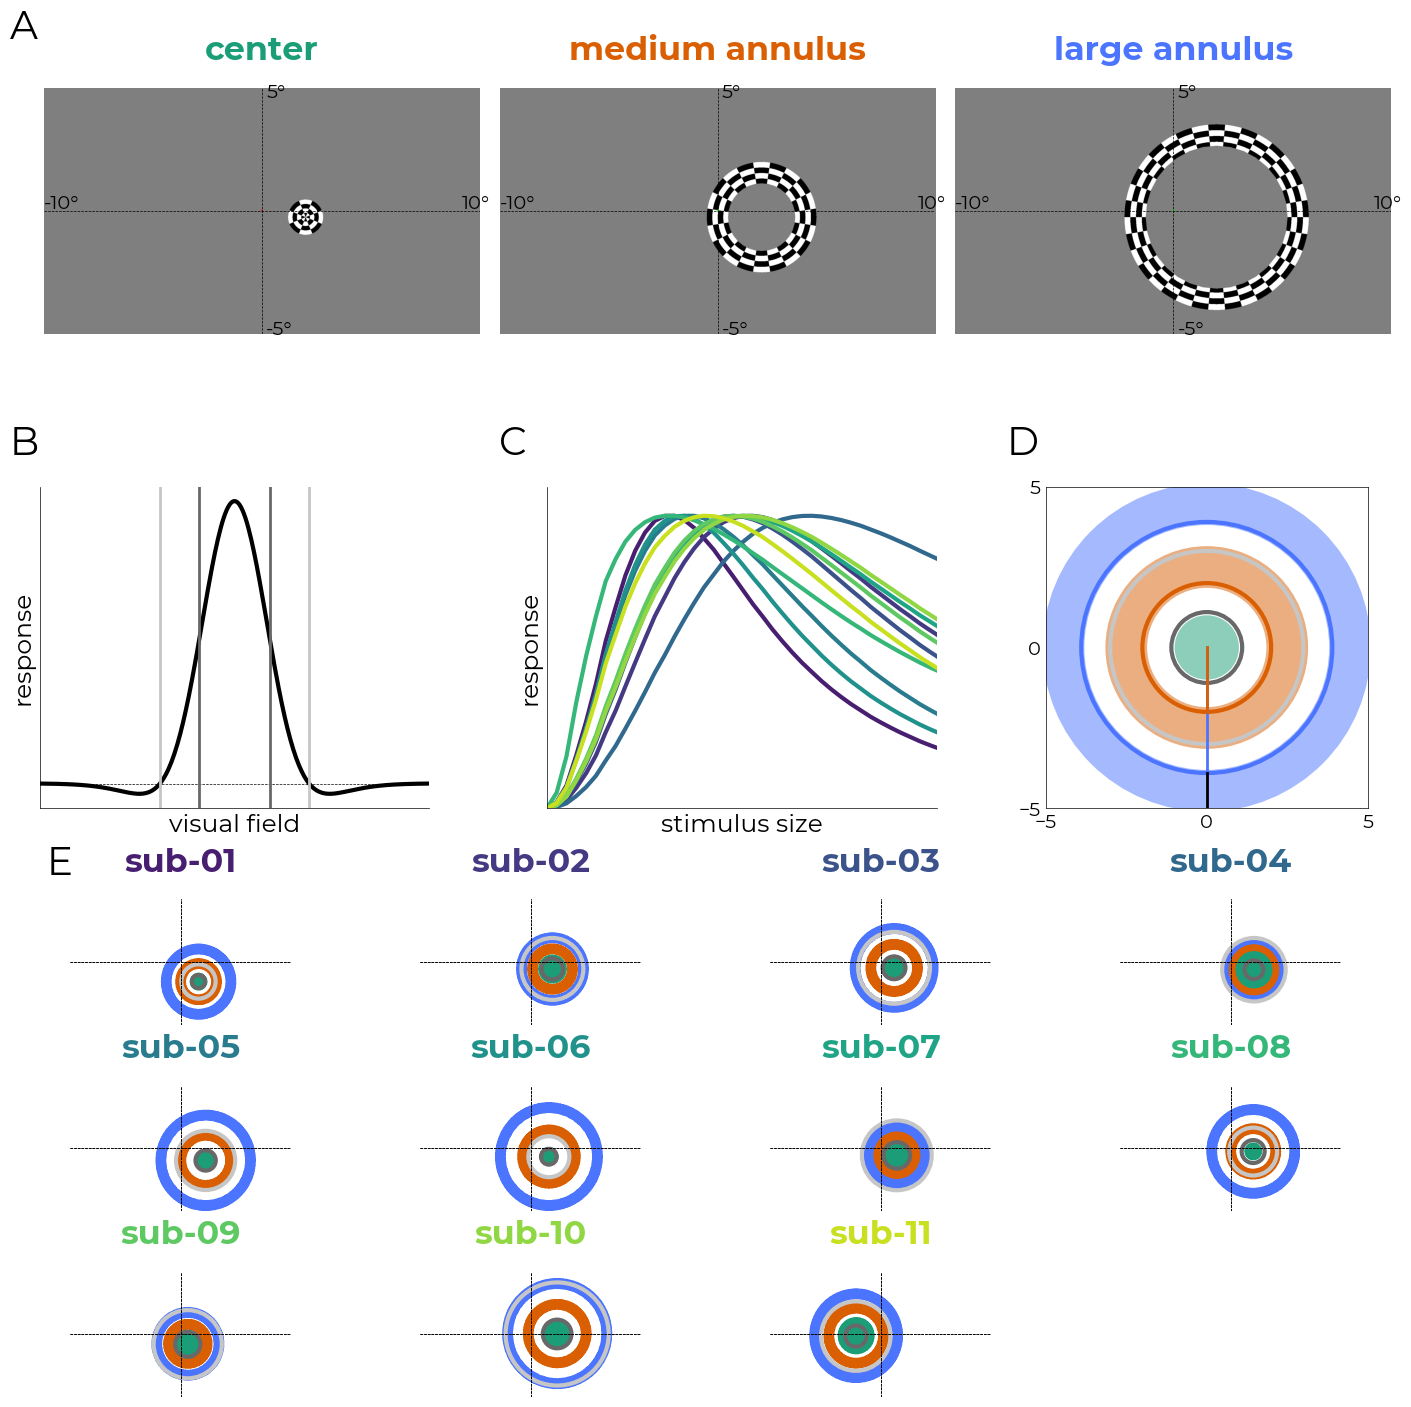

In [19]:
%matplotlib inline
ncols = 4
nrows = int(np.ceil(len(include_subjs)/ncols))

fig = plt.figure(figsize=(14,14), constrained_layout=True)
sfs = fig.subfigures(nrows=3, height_ratios=[0.3,0.3,0.4], hspace=0)
sf1 = sfs[0].subplots(ncols=3)

ref_subj = "sub-013"
scr_obj = hr.viz.StimPNGs(ref_subj)
scr_obj.generate_screen_images(
    axs=sf1, 
    annotate=True
)

axs = sfs[1].subplots(
    ncols=3, 
    gridspec_kw={"wspace": 0.15}
)

prof1d = hr.viz.StimPNGs.get_1d_profile(
    scr_obj.h_pars,
    n_pix=270
)

prof = prof1d.prof_1d.squeeze()
prof /= prof.max()
rf_cm = sns.color_palette("Greys_r", 2)
pl = plotting.LazyPlot(
    prof,
    line_width=3,
    color="k",
    axs=axs[0],
    add_hline=0,
    add_vline={
        "pos": prof1d.zero_cross_pix+[prof1d.metrics.iloc[0].fwhm_obj.t0_,prof1d.metrics.iloc[0].fwhm_obj.t1_],
        "color": [rf_cm[1],rf_cm[1],rf_cm[0],rf_cm[0]],
        "ls": "solid",
        "lw": 2
    },
    x_label="visual field",
    y_label="response",
    # y_lim=[0,prof.max()*1.1],
    x_ticks=[],
    y_ticks=[]
)

cm = sns.color_palette("viridis", len(include_subjs))
for ix,i in enumerate(include_subjs):
    sub = f"sub-{i}"
    obj = hr.viz.StimPNGs(sub, n_pix=None)
    obj.plot_srf(
        axs=axs[1],
        annot=False,
        labels=True,
        normalize=True,
        color=cm[ix]
    )

hr.viz.ExampleStims(axs=axs[-1])

sf3 = sfs[2].subplots(ncols=ncols, nrows=nrows)
objs = {}
for ix,ax in enumerate(sf3.flatten()):

    if (ix+1)>len(include_subjs):
        # remove obsolete axes
        ax.remove()
    else:
        sub = f"sub-{include_subjs[ix]}"
        print(f"plotting '{sub}'")
        png_obj = hr.viz.StimPNGs(sub, n_pix=270)   
        png_obj.generate_composite(
            axs=ax, 
            annotate=False, 
            title={
                "title": f"sub-{str(ix+1).zfill(2)}", 
                "fontweight": "bold",
                "color": cm[ix]
            },
            add_prf=True
        )

        objs[sub] = png_obj

plotting.fig_annot(
    fig,
    axs=[
        fig.axes[0],
        fig.axes[3],
        fig.axes[4],
        fig.axes[5],
        fig.axes[6]
    ],
    x0_corr=-0.25,
    x_corr=[-0.25,-0.4,-0.4,-0.25],
    y=[1.2,1.1,1.1,1.1,1.2]
)

hr.viz._save_figure(
    fig, 
    fname="group_desc-composite_stims4", 
    overwrite=True
)

In [8]:
# png_obj = hr.viz.StimPNGs(sub, n_pix=None)   
# png_obj.generate_composite(
#     # axs=ax, 
#     annotate=False, 
#     title={
#         "title": f"sub-{str(ix+1).zfill(2)}", 
#         "fontweight": "bold",
#         "color": "k"
#     },
#     add_prf=True,
# )

### Epoching method & targeting

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.6s finished


{'vmin': -4.5, 'vmax': 4.5}
{'cm_nr': 3, 'vmin': -4.5, 'vmax': 4.5, 'axs': <Axes: label='<colorbar>'>}
Writing '/data1/projects/MicroFunc/Jurjen/programs/project_repos/holeresponse/images/fig_desc-method_targeting.png'
Writing '/data1/projects/MicroFunc/Jurjen/programs/project_repos/holeresponse/images/fig_desc-method_targeting.pdf'
Writing '/data1/projects/MicroFunc/Jurjen/programs/project_repos/holeresponse/images/fig_desc-method_targeting.svg'


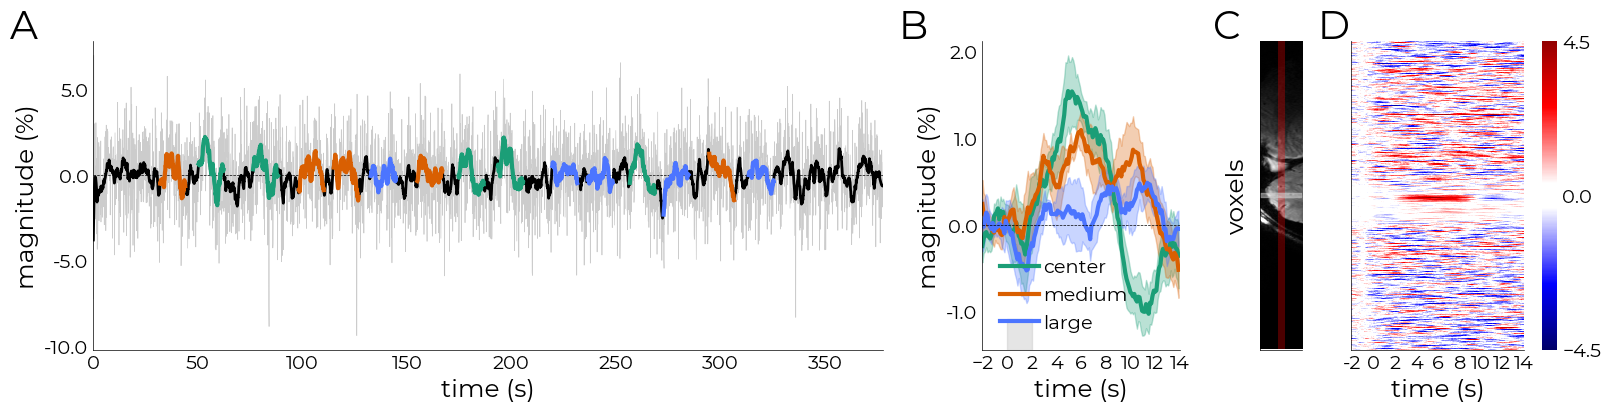

In [167]:
%matplotlib inline
subj = "sub-013"
fig = plt.figure(
    figsize=(16,4),
    constrained_layout=True
)

sfs = fig.subfigures(ncols=2, width_ratios=[0.75,0.25])
ep_fig = hr.viz.EpochMethod(
    utils.get_file_from_substring([subj], h5_files),
    data_kws={
        "compartments": 20,
        "lp_kw": {
            "window_length": 31
        },
        "lp": True,
        "unique_ribbon": True
    },
    TR=0.105,
    interval=[-2,14],
    plot_kws={
        "y_dec": 1,
        "labels": [
            "center", 
            "medium", 
            "large"
        ]
    },
    axs=sfs[0],
    add_titles=False
)

axs = sfs[1].subplots(
    ncols=2,
    sharey=True,
    width_ratios=[0.25,0.8],
    gridspec_kw={
        "wspace": -0.9
    }
)

imgs = {}
ref_slc = subj_obj.get_slc(subj)
ref_beam = subj_obj.get_beam(subj)
for img,ff in zip(["slice","beam"],[ref_slc,ref_beam]):

    if isinstance(ff, str):
        imgs[img] = nb.load(ff).get_fdata().squeeze()
    else:
        raise TypeError(f"{ff} is of type {type(ff)}. Must be a string pointing to a path")

for cm,cr,key,alpha,v in zip(
    ["Greys_r","r"],
    [False,True],
    list(imgs.keys()),
    [None,0.3],
    [2500,1],
    ):
    
    if cr:
        cm = utils.make_binary_cm(cm)

    im = axs[0].imshow(
        imgs[key][:,310:410],
        cmap=cm,
        alpha=alpha,
        vmax=v
    )

plotting.conform_ax_to_obj(
    ax=axs[0],
    x_ticks=[],
    y_label="voxels",
    y_ticks=np.linspace(0,imgs[key].shape[1],5, dtype=int),
    y_ticklabels=[str(int(i)) for i in np.linspace(0,imgs[key].shape[1],5, dtype=int)[::-1]],
    y_lim=[0,imgs[key].shape[0]],
    trim_bottom=True
)

crit = subj_obj.get_slc_criteria(subj)
rib_dict = subj_obj.has_ribdict(subj)
if rib_dict:
    rib_ddict = subj_obj.get(subj, "rib_dict")
    ribbon = rib_ddict[crit[0].split('-')[-1]][crit[1]]
else:
    ribbon = subj_obj.get_ribbon(subj)

axs[0].axhspan(
    *ribbon, 
    alpha=0.5, 
    color="#cccccc"
)

sub_line = utils.select_from_df(
    line_df, 
    expression=f"subject = {subj.split('-')[-1]}"
).groupby(
    [
        "event_type",
        "t"
    ]
).mean()

# make colormap more white
import matplotlib as mpl
from matplotlib.colors import ListedColormap
white_block = np.full((20,4), (1,1,1,1))
seis = mpl.colormaps["seismic"].resampled(256)
new = seis(np.linspace(0,1,256))

# define center
center = new.shape[0]//2
block_size = white_block.shape[0]//2
start,end = center-block_size,center+block_size

# move gradient to extremes
new[0:start,:] = new[block_size:center,:]
new[end:,:] = new[center:,:][:-block_size]
# insert white block
new[start:end,:] = white_block 
cm1 = ListedColormap(new)
cm1

ref_ev = "act"
xy = hr.viz.XinYuPlot.single_xinyu_plot(
    utils.select_from_df(sub_line, expression=f"event_type = {ref_ev}"),
    axs=axs[-1],
    force_int=True,
    time_dec=0,
    time_ticks=9,
    # y_ticks=[],
    as_depth=False,
    # bsl=20,
    sns_kws={
        "vmin": -4.5,
        "vmax": 4.5
    },
    annot_color="k",
    y_lbl=None,
    contours=False,
    annot=False,
    annot_ribbon=False,
    bsl=20,
    cb_kws={
        "cm_nr": 3
    },
    cm=cm1
)

plotting.fig_annot(
    fig,
    axs=list(fig.axes)[:-1],
    x0_corr=-0.85,
    x_corr=[-0.85,-0.35,-0.2]
)

hr.viz._save_figure(
    fig, 
    fname="fig_desc-method_targeting", 
    overwrite=True,
    exts=["png","pdf","svg"]
)

### Subject-specific profiles averaged across depth

Plotting 001
Plotting 002
Plotting 005
Plotting 006
Plotting 008
Plotting 010
Plotting 011
Plotting 013
Plotting 014
Plotting 015
Plotting 022
Plotting average
Adding insets
Writing '/data1/projects/MicroFunc/Jurjen/programs/project_repos/holeresponse/images/group_desc-epochs_subjects_wilcox_holm.pdf'
Writing '/data1/projects/MicroFunc/Jurjen/programs/project_repos/holeresponse/images/group_desc-epochs_subjects_wilcox_holm.png'
Writing '/data1/projects/MicroFunc/Jurjen/programs/project_repos/holeresponse/images/group_desc-epochs_subjects_wilcox_holm.svg'


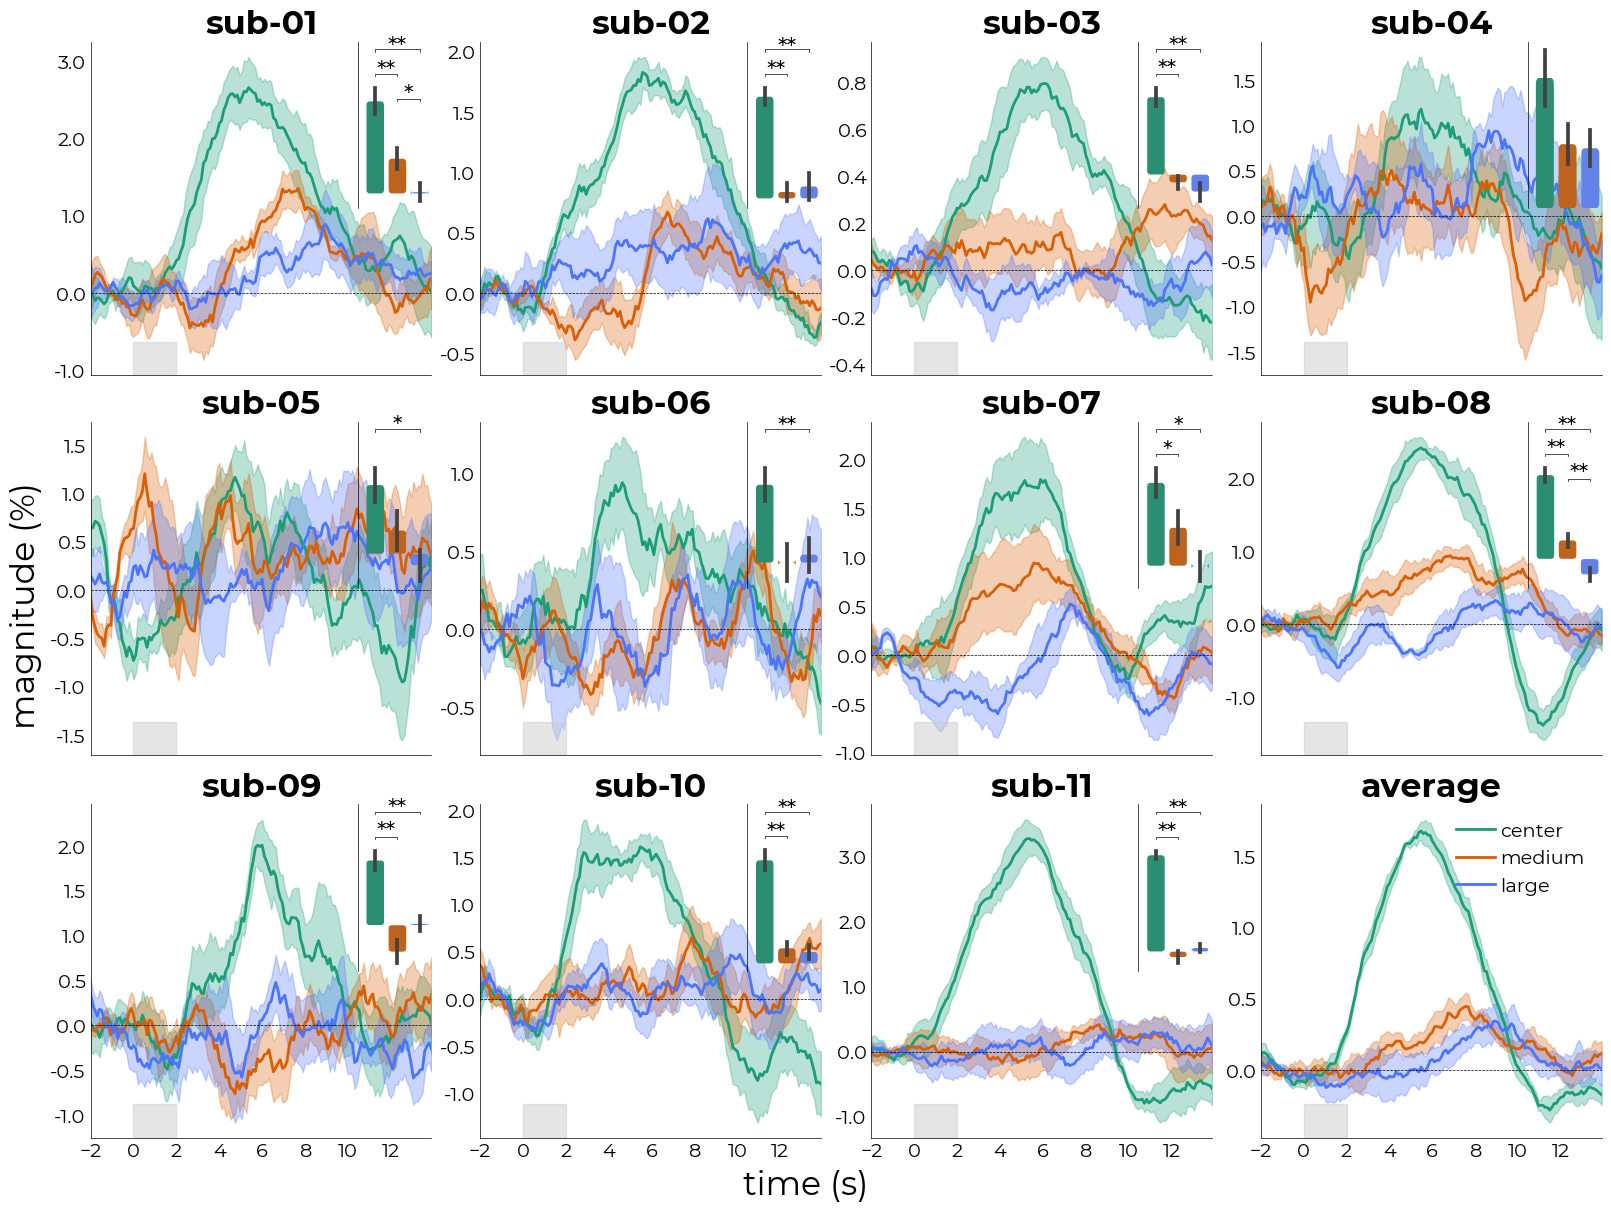

In [281]:
%matplotlib inline

ncols = 4
nrows = int(np.ceil(len(include_subjs)/ncols))
fig,axs = plt.subplots(
    figsize=(ncols*4,nrows*4),
    ncols=ncols,
    nrows=nrows,
    constrained_layout=True,
    sharex=True
)

#----------------------------------------------------------------------------------------------------------------------------------
# Subplots

sub_ax = {}
for ix,ax in enumerate(axs.flatten()):

    if (ix+1)>len(include_subjs):

        print(f"Plotting average")

        grand_avg = pd.concat([utils.select_from_df(sub_df, expression=f"subject = {i}") for i in include_subjs])
        grand_avg = grand_avg.groupby(["event_type","epoch","t"]).mean()
        avg_epoch = hr.viz.PlotEpochProfiles(
            grand_avg["gm"],
            ev_names=["center","medium","large"],
            cm=subj_obj.get_colors(),
            bsl=20,
            axs=ax,
            y_label=None,
            x_label=None            
        )

        ax.set_title(
            "average", 
            fontsize=24, 
            fontweight="bold"
        )

    else:

        sub = include_subjs[ix]
        print(f"Plotting {sub}")
        # print(f"col_nr = {col_nr}; row_nr = {row_nr}")

        select_sub = utils.select_from_df(sub_df, expression=f"subject = {sub}")
        t_ = utils.get_unique_ids(select_sub, id="t")
        sub_gm = utils.select_from_df(select_sub, expression="ribbon", indices=[0])
        avg_epoch = hr.viz.PlotEpochProfiles(
            sub_gm.groupby(["subject","event_type", "epoch","t"]).mean(),
            axs=ax,
            ev_names=["center","near","far"],
            cm=subj_obj.get_colors(),
            bsl=20,
            x_ticks=np.arange(t_[0],t_[-1]*1.1, step=2),
            y_dec=1,
            labels=None,
            y_label=None,
            x_label=None
        )
        
        sub_name = f"sub-{str(ix+1).zfill(2)}"
        # sub_name = f"sub-{sub}"
        ax.set_title(
            sub_name, 
            fontsize=24, 
            fontweight="bold"
        )

        sub_ax[sub] = ax.inset_axes([0.8,0.5,0.2,0.5])

# add barplots as insets
print("Adding insets")
sub_excl = []
for i in include_subjs:
    sub_excl.append(utils.select_from_df(sub_df, expression=f"subject = {i}"))
sub_excl = pd.concat(sub_excl)

tm = hr.viz.MagnitudePerEvent(
    hr.data.melt_epochs(sub_excl), # use average of order-specific runs (usually 2 for each subj, so 2x5 averages = 10 points)
    # add_points=True,
    interval="custom",
    points_color="k",
    y_dec=1,
    palette=subj_obj.get_colors(),
    sns_offset=4,
    add_title=False,
    as_index=True,
    fancy=True,
    # posth=False,
    axs=sub_ax,
    ticks=[],
    plot_kws={
        "y_pos": 1.25,
        "line_separate_factor": -0.2,
        "ast_frac": -0.05
    },
    parametric=False,
    posthoc_kw={
        "effsize": "cohen",
        "paired": True,
        "padjust": "holm"
    }    
)

fig.supylabel("magnitude (%)", fontsize=24)
fig.supxlabel("time (s)", fontsize=24)
hr.viz._save_figure(
    fig, 
    fname="group_desc-epochs_subjects_wilcox_holm", 
    overwrite=True
)

In [315]:
max_file = opj(subj_obj.repo_dir,"data","t_max.csv")
if not os.path.exists(max_file):
    print(f"Writing to '{max_file}'")
    tm.max_df.to_csv(max_file)
    max_data = tm.max_df.copy()
else:
    print(f"Reading '{max_file}'")
    max_data = pd.read_csv(max_file)

try:
    max_data = max_data.reset_index()
except:
    pass

Reading '/data1/projects/MicroFunc/Jurjen/programs/project_repos/holeresponse/data/t_max.csv'


In [316]:
import statsmodels.formula.api as smf

# Fit the mixed-effects model: testing whether `gm` differs across `event_type` with `subject` as random effects
model = smf.mixedlm(
    "gm ~ event_type", 
    max_data, 
    groups=max_data["subject"]
)
result = model.fit()

# Display the summary of the model results
print(result.summary())
print(result.summary().as_latex())



              Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    gm       
No. Observations:     330        Method:                REML     
No. Groups:           11         Scale:                 0.4186   
Min. group size:      30         Log-Likelihood:        -336.6259
Max. group size:      30         Converged:             Yes      
Mean group size:      30.0                                       
-----------------------------------------------------------------
                      Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept              1.478    0.094  15.770 0.000  1.294  1.662
event_type[T.suppr_1] -1.218    0.087 -13.961 0.000 -1.389 -1.047
event_type[T.suppr_2] -1.361    0.087 -15.604 0.000 -1.532 -1.190
Group Var              0.055    0.048                            

\begin{table}
\caption{Mixed Linear Model Regression Results}
\label{}
\begin{center}
\be

In [318]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import numpy as np

# Perform pairwise comparisons between event types using Tukey's HSD
pairwise_results = pairwise_tukeyhsd(max_data['gm'], max_data['event_type'])

# Display the results
pairwise_results.summary()

<class 'statsmodels.iolib.table.SimpleTable'>

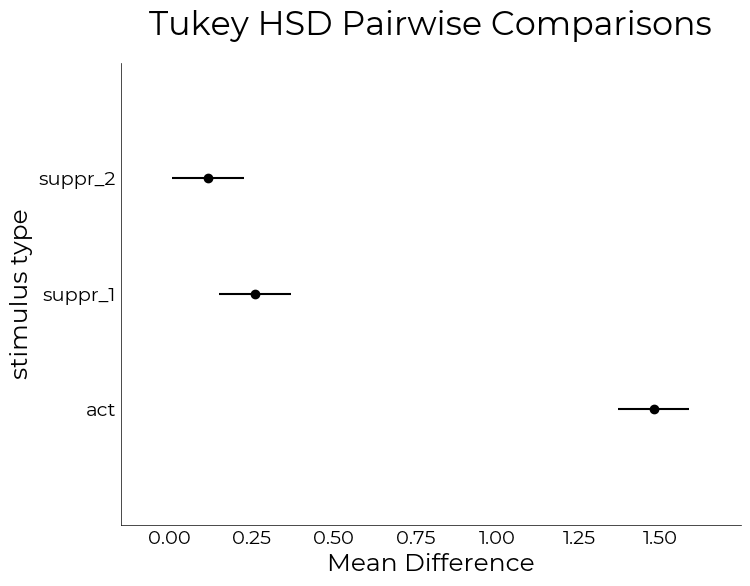

In [319]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Plot the Tukey HSD results
fig = pairwise_results.plot_simultaneous(figsize=(8, 6))
pl = plotting.conform_ax_to_obj(
    ax=fig.axes[0],
    title="Tukey HSD Pairwise Comparisons",
    x_label="Mean Difference",
    y_label="stimulus type"

)

### GLMs

In [89]:
glms = pd.read_csv(opj(subj_obj.repo_dir,"data","center_large_glm_projections.csv"))
glms

Unnamed: 0      beta     tstat        r2  subject        model  model_ix  \
0             0  0.981313  2.956407  0.326860        8       linear         0   
1             0 -0.398325 -1.404422  0.396841        8        camel         1   
2             0 -1.791440 -2.029122  0.606952        8  camel_deriv         2   
3             1  0.678075  3.011143  0.334983       10       linear         0   
4             1  0.469938  2.792047  0.544059       10        camel         1   
..          ...       ...       ...       ...      ...          ...       ...   
454           9 -0.549536 -2.120864  0.427166       15        camel         1   
455           9 -1.595243 -2.136857  0.680206       15  camel_deriv         2   
456          10  1.093579  4.921469  0.573670       22       linear         0   
457          10  0.452464  2.694858  0.701281       22        camel         1   
458          10  1.633326  3.066857  0.797870       22  camel_deriv         2   

    method preproc      event_type  
0      raw  uncorr          center  
1      raw  uncorr          center  
2      raw  uncorr          center  
3      raw  uncorr          center  
4      raw  uncorr          center  
..     ...     ...             ...  
454   norm    corr  large\nannulus  
455   norm    corr  large\nannulus  
456   norm    corr  large\nannulus  
457   norm    corr  large\nannulus  
458   norm    corr  large\nannulus  

[459 rows x 10 columns]

In [3]:
all_profiles = pd.read_csv(opj(subj_obj.repo_dir,"data","camel_profiles.csv")).set_index(["preproc","method","event_type","subject"])
all_betas = pd.read_csv(opj(subj_obj.repo_dir,"data","camel_betas.csv")).set_index(["event_type","method","preproc","model","model_ix"])

In [ ]:
prof_pivot = utils.multiselect_from_df(
    all_profiles,
    expression=[
        "preproc = corr",
        "method = norm",
    ]
)
prof_pivot.reset_index(inplace=True)
prof_pivot.drop(["preproc","method"], inplace=True, axis=1)
prof_pivot.set_index(["event_type", "subject"], inplace=True)
reg_df = pd.DataFrame(reg_dict["camel_deriv"], columns=["linear","peak_upper","deriv_upper", "peak_deep", "deriv_deep"])

0         1         2         3         4  \
event_type      subject                                                     
center          1        3.060355  3.061141  2.894289  2.879197  2.551745   
                2        2.500304  2.677791  2.157537  1.789043  1.707960   
                5        2.560171  2.688448  2.087187  1.684478  1.574658   
                6        1.872767  1.987979  1.641197  1.446175  1.345055   
                8        4.006025  3.704616  1.457791  1.462933  2.144702   
                10       2.366752  2.563166  2.121649  1.831891  1.650922   
                11       2.597183  2.714311  2.314777  2.067002  1.852390   
                13       3.285149  3.327475  3.112992  2.994997  2.659564   
                14       1.784546  2.044245  1.765953  1.436228  1.165421   
                15       2.814012  3.045537  2.417208  1.940639  1.679448   
                22       2.821787  3.097480  2.819189  2.473469  2.186667   
medium\nannulus 1        0.416602  0.752350  0.096321 -0.592437 -0.379552   
                2        0.311210  0.423862  0.214025 -0.028539 -0.102935   
                5        0.425775  0.428543  0.442423  0.391427  0.254008   
                6       -0.182407 -0.713318 -0.082077  0.516437  1.040225   
                8       -0.662657 -0.616576 -0.380265 -0.436029 -0.493761   
                10       0.238647  0.300776  0.240137  0.146771  0.186879   
                11      -0.475601 -0.672766 -0.262968  0.114101  0.175903   
                13       0.022362  0.057584 -0.074582 -0.143849  0.339326   
                14       0.634342  0.738920  0.745694  0.619509  0.567635   
                15       0.209713  0.265986  0.168908  0.039102  0.118171   
                22      -0.030026  0.038230  0.045004 -0.044859 -0.060410   
large\nannulus  1        0.554751  0.259209  1.068859  1.766391  1.370508   
                2        0.143341  0.150386  0.354863  0.447222  0.173370   
                5        0.048535  0.061389  0.291303  0.390567  0.258967   
                6        0.755678  0.935152  0.921269  0.795267  0.568289   
                8       -0.139085  0.130581  1.624737  1.850844  1.598760   
                10       0.647069  0.954992  0.791252  0.515394  0.196500   
                11      -0.104431 -0.162899  0.172603  0.395987  0.556362   
                13       0.011537 -0.026178  0.431297  0.732179  0.672480   
                14       0.218731  0.152847  0.316062  0.460717  0.467160   
                15       0.724743  0.878656  0.789396  0.588017  0.358669   
                22       0.547355  0.682965  0.846180  0.789342  0.594292   

                                5         6         7         8         9  \
event_type      subject                                                     
center          1        2.104351  1.710303  1.430959  1.231197  1.036637   
                2        1.706860  1.664601  1.453538  1.322055  1.314591   
                5        1.468655  1.415332  1.330188  1.387531  1.497411   
                6        1.376033  1.410550  1.575778  2.118351  2.689265   
                8        2.565174  2.803092  1.907660  1.304620  1.185943   
                10       1.656633  1.665882  1.642831  1.703702  1.792915   
                11       1.633011  1.499542  1.578472  1.736983  1.484727   
                13       2.327950  1.833004  1.293529  1.131205  1.111671   
                14       0.898431  0.826956  0.912742  1.078110  1.271818   
                15       1.474228  1.291635  1.131596  1.051138  1.082679   
                22       1.903683  1.668453  1.442726  1.296580  1.178774   
medium\nannulus 1        0.162670  0.571167  0.687118  0.764216  0.532294   
                2       -0.092485 -0.105927 -0.082413 -0.097753 -0.029140   
                5        0.170149  0.001052 -0.254294 -0.225190 -0.117515   
                6        1.071109  1.037439  0.816078  0.371080 -0.119693   
                8        0.

In [66]:
dfs.to_csv(opj(subj_obj.repo_dir,"data","norm_corr_profiles_regressors.csv"))

#### Center vs large

In [90]:
n_steps = all_profiles.shape[-1]
xx = np.arange(0,n_steps)
y1 = xx.copy()[::-1]
y1 = y1/y1.max()

y2 = np.linspace(-n_steps//2,n_steps//2,num=n_steps)
y2 = (y2**2)
y2 = y2/y2.max()

y = np.linspace(-10,10,num=20)
# print(y2.shape)
# y2 = (y2**2)
fc = 5
y_1 = stats.norm.pdf(y,-fc)
y_1 = y_1/y_1.max()
y_1d = np.gradient(y_1)

y_2 = stats.norm.pdf(y,fc)
y_2 = y_2/y_2.max()
y_2d = np.gradient(y_2)

y3 = y_1+y_2

reg_dict = {
    "linear": y1[...,np.newaxis],
    "camel": np.concatenate(
        [
            y1[...,np.newaxis],     # linear term
            y3[...,np.newaxis],    # fixed bumps
        ],
        axis=1
    )
}

# combine linear & camel
reg_dict["camel_deriv"] = np.concatenate(
    [
        y1[...,np.newaxis],     # linear term
        y_1[...,np.newaxis],    # first bump
        y_2[...,np.newaxis],    # second bump
        y_1d[...,np.newaxis],   # first bump deriv
        y_2d[...,np.newaxis]    # second bump deriv
    ],
    axis=1
)


              W      pval  normal
beta  0.939402  0.192378    True

        Source  ddof1  ddof2          F     p-unc      np2
0  event_type      1     20  10.310854  0.004384  0.34017


Contrast       A               B  Paired  Parametric         T   dof  \
0  event_type  center  large\nannulus    True        True -4.005559  10.0   

  alternative     p-unc   BF10     cohen  distances  
0   two-sided  0.002496  18.86 -1.369197          1

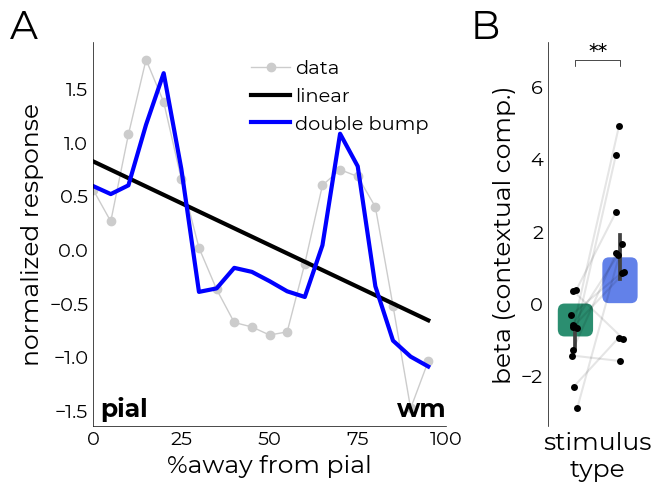

In [291]:
%matplotlib inline
n_elem = all_betas.shape[1]

colors = sns.color_palette("viridis", n_elem)
ev = "large\nannulus"
expr = [
    f"event_type = {ev}",
    "method = norm"
]

be = utils.multiselect_from_df(
    all_betas,
    expression=expr
)

data = utils.multiselect_from_df(all_profiles, expression=expr+["preproc = corr","method = norm"]).values.T

icpt = np.ones((data.shape[0],1))
fig,axs = plt.subplots(
    ncols=2, 
    width_ratios=[0.8,0.2], 
    constrained_layout=True
)

ix = 0
sub_name = f"sub-{str(ix+1).zfill(2)}"
lbl = {
    "linear": "linear",
    "camel": "double",
    "camel_deriv": "double bump"
}

incl_models = [
    "linear",
    "camel_deriv"
]
data_list = [data[:,ix]]
# cm = sns.color_palette("Reds", len(incl_models))
cm = ["k","b"]

for key,val in reg_dict.items():
    
    if key in incl_models:
        be1 = utils.select_from_df(be, expression=f"model = {key}").values
        dm = np.concatenate([icpt,val], axis=-1)

        y_hat = np.dot(dm,be1)
        data_list.append(y_hat[:,ix])

ddict = hr.viz.make_wm_pial_ticks(data_list[0])
def_dict = {
    "color": ["#cccccc"]+cm,
    "axs": axs[0],
    "line_width": [1]+[3 for i in range(len(incl_models))],
    "markers": ["o"]+[None for i in range(len(incl_models))],
    "labels": ["data"]+[lbl[i] for i in incl_models],
    "x_ticks": ddict["ticks"],
    "x_ticklabels": ddict["labels"],
    "x_label": "%away from pial",
    "y_label": "normalized response",
}

pl = plotting.LazyPlot(
    data_list,
    **def_dict
)

hr.viz.annotate_cortical_ribbon(
    axs[0],
    pial_pos=(0.02,0.025),
    wm_pos=(0.86,0.025),
    fontsize=pl.font_size,
    fontweight="bold"
)

stat = "beta"
if stat == "tstat":
    lbl = "t-stat"
else:
    lbl = stat
    
br = plotting.LazyBar(
    utils.multiselect_from_df(
        glms,
        expression=[
            "preproc = corr",
            "method = norm",
            "event_type != medium\nannulus",
            "model = camel_deriv"
        ]
    ),
    x="event_type",
    y=stat,
    x_label="stimulus\ntype",
    axs=axs[1],
    add_points=True,
    points_color="k",
    y_label=f"{lbl} (contextual comp.)",
    sns_offset=4,
    bar_legend=True,
    sns_rot=-25,
    # title={
    #     "title": f"{key} | {vi}",
    #     "fontweight": "bold"
    # },
    bbox_to_anchor=(0.8,0.9),
    fancy=True,
    palette=subj_obj.ev_colors[::2],
    connect=True
)

normality = pg.normality(br.data[br.y])
is_normal = normality["normal"][0]
aov = glm.ANOVA(
    data=br.data,
    dv=br.y,
    between=br.x,
    # test="test",
    parametric=is_normal,
    posthoc_kw={
        "effsize": "cohen",
        "test": "test",
        "paired": True,
        "subject": "subject",
        "padjust": "hilm"
    }
)

aov.plot_bars( 
    axs=br.ff,
    ast_frac=0,
    y_pos=1.15,
    line_separate_factor=-0.075
)

plotting.fig_annot(
    fig,
    axs=list(fig.axes),
    x0_corr=-0.85,
    x_corr=[-0.85]
)

hr.viz._save_figure(
    fig, 
    fname=f"stat-{stat}_double_bump_ev-cf", 
    # overwrite=True
)

print("\n", normality)
print("\n", aov.ano)
aov.posthoc


#### Add medium to the mix


              W      pval  normal
beta  0.948999  0.124379    True

        Source  ddof1  ddof2         F     p-unc       np2
0  event_type      2     30  7.107614  0.002973  0.321501


Contrast               A                B  Paired  Parametric         T  \
0  event_type          center   large\nannulus    True        True -4.005559   
1  event_type          center  medium\nannulus    True        True -3.146138   
2  event_type  large\nannulus  medium\nannulus    True        True  1.330295   

    dof alternative     p-unc    p-corr p-adjust   BF10     cohen  distances  
0  10.0   two-sided  0.002496  0.007488     holm  18.86 -1.369197          2  
1  10.0   two-sided  0.010401  0.020802     holm  5.864 -1.505014          1  
2  10.0   two-sided  0.212961  0.212961     holm  0.603  0.571084          1

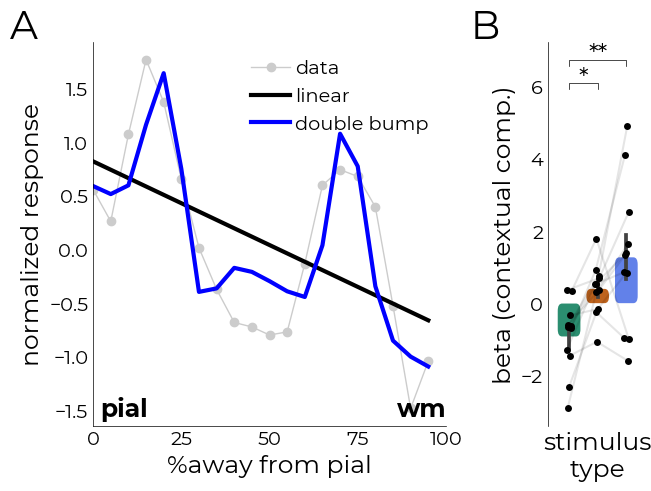

In [292]:
%matplotlib inline
n_elem = all_betas.shape[1]

colors = sns.color_palette("viridis", n_elem)
ev = "large\nannulus"
expr = [
    f"event_type = {ev}",
    "method = norm"
]

be = utils.multiselect_from_df(
    all_betas,
    expression=expr
)

data = utils.multiselect_from_df(all_profiles, expression=expr+["preproc = corr","method = norm"]).values.T

icpt = np.ones((data.shape[0],1))
fig,axs = plt.subplots(
    ncols=2, 
    width_ratios=[0.8,0.2], 
    constrained_layout=True
)

ix = 0
sub_name = f"sub-{str(ix+1).zfill(2)}"
lbl = {
    "linear": "linear",
    "camel": "double",
    "camel_deriv": "double bump"
}

incl_models = [
    "linear",
    "camel_deriv"
]
data_list = [data[:,ix]]
# cm = sns.color_palette("Reds", len(incl_models))
cm = ["k","b"]

for key,val in reg_dict.items():
    
    if key in incl_models:
        be1 = utils.select_from_df(be, expression=f"model = {key}").values
        dm = np.concatenate([icpt,val], axis=-1)

        y_hat = np.dot(dm,be1)
        data_list.append(y_hat[:,ix])

ddict = hr.viz.make_wm_pial_ticks(data_list[0])
def_dict = {
    "color": ["#cccccc"]+cm,
    "axs": axs[0],
    "line_width": [1]+[3 for i in range(len(incl_models))],
    "markers": ["o"]+[None for i in range(len(incl_models))],
    "labels": ["data"]+[lbl[i] for i in incl_models],
    "x_ticks": ddict["ticks"],
    "x_ticklabels": ddict["labels"],
    "x_label": "%away from pial",
    "y_label": "normalized response",
}

pl = plotting.LazyPlot(
    data_list,
    **def_dict
)

hr.viz.annotate_cortical_ribbon(
    axs[0],
    pial_pos=(0.02,0.025),
    wm_pos=(0.86,0.025),
    fontsize=pl.font_size,
    fontweight="bold"
)

stat = "beta"
if stat == "tstat":
    lbl = "t-stat"
else:
    lbl = stat
    
br = plotting.LazyBar(
    utils.multiselect_from_df(
        glms,
        expression=[
            "preproc = corr",
            "method = norm",
            "model = camel_deriv"
        ]
    ),
    x="event_type",
    y=stat,
    x_label="stimulus\ntype",
    axs=axs[1],
    add_points=True,
    points_color="k",
    y_label=f"{lbl} (contextual comp.)",
    sns_offset=4,
    bar_legend=True,
    sns_rot=-25,
    # title={
    #     "title": f"{key} | {vi}",
    #     "fontweight": "bold"
    # },
    bbox_to_anchor=(0.8,0.9),
    fancy=True,
    palette=subj_obj.ev_colors,
    connect=True
)


normality = pg.normality(br.data[br.y])
is_normal = normality["normal"][0]

aov = glm.ANOVA(
    data=br.data,
    dv=br.y,
    between=br.x,
    # test="test",
    parametric=is_normal,
    posthoc_kw={
        "effsize": "cohen",
        "test": "test",
        "paired": True,
        "subject": "subject",
        "padjust": "holm"
    }
)

aov.plot_bars( 
    axs=br.ff,
    ast_frac=0,
    y_pos=1.15,
    line_separate_factor=-0.075
)

plotting.fig_annot(
    fig,
    axs=list(fig.axes),
    x0_corr=-0.85,
    x_corr=[-0.85]
)

hr.viz._save_figure(
    fig, 
    fname=f"stat-{stat}_double_bump_ev-cnf", 
    # overwrite=True
)

print("\n", normality)
print("\n", aov.ano)
aov.posthoc

In [153]:
pg.homoscedasticity(br.data, dv=br.y, group="event_type")

W      pval  equal_var
levene  0.793258  0.461629       True

### fMRI vs ephys

In [315]:
comp_excl = pd.concat([utils.select_from_df(comp_df, expression=f"subject = {sub}") for sub in include_subjs])

comp_excl.head()

0         1         2  \
subject task run event_type epoch t                                         
001     SRFa 1   act        0     -2.000000  0.630385 -0.239497  1.500266   
                                  -1.894737  0.571895 -0.321802  1.465591   
                                  -1.789474 -0.009266 -1.035793  1.017260   
                                  -1.684211 -0.992481 -1.888901 -0.096061   
                                  -1.578947 -1.135379 -1.780816 -0.489943   

                                                    3         4         5  \
subject task run event_type epoch t                                         
001     SRFa 1   act        0     -2.000000  3.240028  2.311503  0.493548   
                                  -1.894737  3.252984  2.429860  0.736565   
                                  -1.789474  3.070313  2.421918  0.873040   
                                  -1.684211  1.696778  1.634299  0.953380   
                                  -1.578947  0.800929  0.760801  0.277005   

                                                    6         7         8  \
subject task run event_type epoch t                                         
001     SRFa 1   act        0     -2.000000 -0.636957  0.294886  1.226730   
                                  -1.894737 -0.339304  0.437110  1.213524   
                                  -1.789474 -0.095066  0.679145  1.453356   
                                  -1.684211  0.615390  1.306187  1.996985   
                                  -1.578947  0.188339  1.285059  2.381780   

                                                    9        10        11  \
subject task run event_type epoch t                                         
001     SRFa 1   act        0     -2.000000  0.187664 -1.508370 -2.492625   
                                  -1.894737  0.055865 -1.746485 -2.736501   
                                  -1.789474  0.286776 -1.526734 -2.603170   
                                  -1.684211  0.737841 -1.171282 -2.353904   
                                  -1.578947  1.129384 -0.906050 -2.245660   

                                                   12        13        14  \
subject task run event_type epoch t                                         
001     SRFa 1   act        0     -2.000000 -1.341541 -0.190457 -0.026837   
                                  -1.894737 -1.289514  0.157472  0.435645   
                                  -1.789474 -1.468380 -0.333591  0.092663   
                                  -1.684211 -1.357018 -0.360133 -0.049205   
                                  -1.578947 -1.497797 -0.749934 -0.415443   

                                                   15        16        17  \
subject task run event_type epoch t                                         
001     SRFa 1   act        0     -2.000000 -0.192371 -0.369028 -0.579055   
                                  -1.894737  0.324214  0.270976  0.392322   
                                  -1.789474  0.282739  0.469596  0.646800   
                                  -1.684211  0.033069  0.215174  0.696770   
                                  -1.578947 -0.218742  0.082698  0.698356   

                                                   18        19  
subject task run event_type epoch t                              
001     SRFa 1   act        0     -2.000000 -0.789081 -0.684068  
                                  -1.894737  0.513668  0.452995  
                                  -1.789474  0.824003  0.735401  
                                  -1.684211  1.178366  0.937568  
                                  -1.578947  1.314014  1.006185

center
{'vmin': -4, 'vmax': 4}
{'vmin': -4, 'vmax': 4, 'axs': <Axes: label='<colorbar>'>}
medium annulus
{'vmin': -4, 'vmax': 4}
{'vmin': -4, 'vmax': 4, 'axs': <Axes: label='<colorbar>'>}
large annulus
{'vmin': -4, 'vmax': 4}
{'vmin': -4, 'vmax': 4, 'axs': <Axes: label='<colorbar>'>}
Writing '/data1/projects/MicroFunc/Jurjen/programs/project_repos/holeresponse/images/group_desc-depth_imshow_profiles2.pdf'
Writing '/data1/projects/MicroFunc/Jurjen/programs/project_repos/holeresponse/images/group_desc-depth_imshow_profiles2.png'
Writing '/data1/projects/MicroFunc/Jurjen/programs/project_repos/holeresponse/images/group_desc-depth_imshow_profiles2.svg'


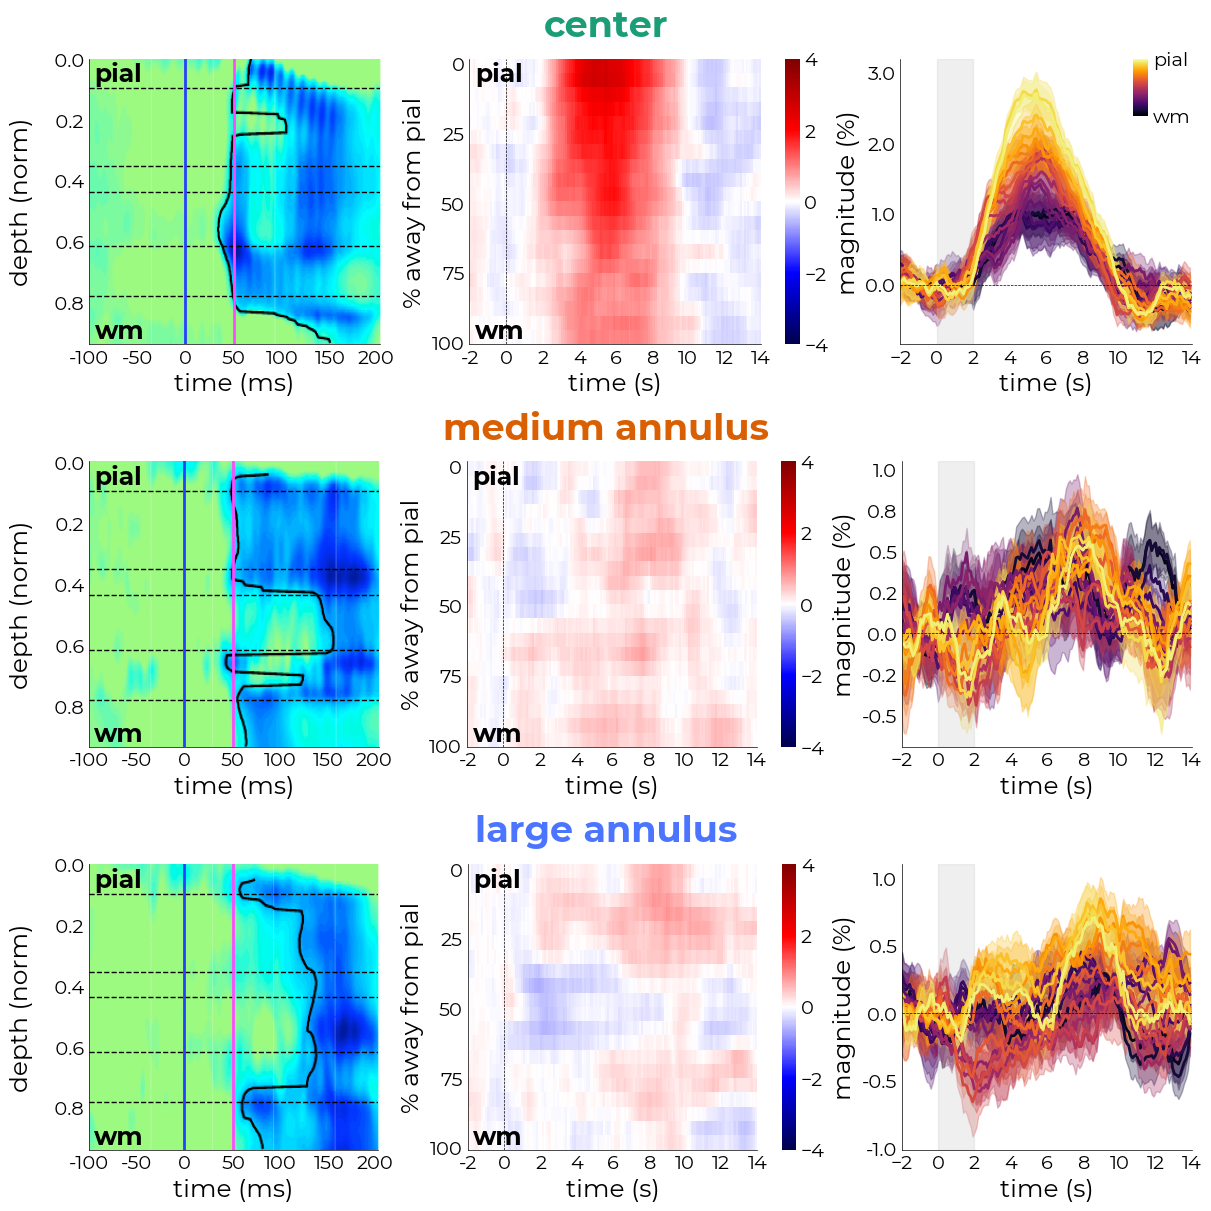

In [338]:
# ephys vs fmri
evs = utils.get_unique_ids(comp_excl, id="event_type")
fig = plt.figure(figsize=(12,12), constrained_layout=True)
sf = fig.subfigures(nrows=len(evs))

ref_data = comp_excl.groupby(["subject","event_type","t"]).mean()
tcs = {}
for ix,(ev,nn) in enumerate(zip(evs,subj_obj.get_evs())):
    
    print(nn)
    axs = sf[ix].subplots(ncols=3)

    # plot Bijanzadeh fiures
    ax1 = axs[0]
    b_ = hr.viz.BijanzadehFigures.plot_single_bijanzadeh(
        subj_obj.bijanzadeh_figures[nn],
        axs=ax1,
        x_label="time (ms)",
        y_label="depth (norm)"
    )


    # fMRI 
    in_data = comp_excl.groupby(["event_type","t"]).mean()
    ax2 = axs[1]
    xy = hr.viz.XinYuPlot.single_xinyu_plot(
        utils.select_from_df(in_data, expression=f"event_type = {ev}"),
        axs=ax2,
        force_int=True,
        time_dec=0,
        time_ticks=9,
        depth_ticks=5,
        # bsl=20,
        sns_kws={
            "vmin": -4,
            "vmax": 4
        },
        annot_color="k",
        contours=False,
        annot_onset=True,
        bsl=20
    )
    
    # Profiles
    ax3 = axs[2]
    if ix == 0:
        add_lbl = [f"{int(i)}%" for i in np.linspace(0,100,in_data.shape[0])]
    else:
        add_lbl = None
    
    grouper = utils.select_from_df(
        ref_data, 
        expression=f"event_type = {ev}"
    ).groupby(["t"])

    # get SEM from original inputs | profile list from "orig"-keys = shifted baseline
    sem_data = list(grouper.sem().values.T)
    prof_data = list(xy["orig"].values.T)

    # get time axis
    t_ = utils.get_unique_ids(ref_data, id="t")
    pl = plotting.LazyPlot(
        prof_data[::-1],
        xx=t_,
        x_ticks=np.arange(t_[0],t_[-1]*1.1, step=2),
        axs=ax3,
        cmap="inferno",
        add_hline=0,
        x_label="time (s)",
        y_label="magnitude (%)",
        line_width=2,
        y_dec=1,
        error=sem_data
    )

    tcs[nn] = prof_data
    
    # make colorbar for depth
    if ix == 0:
        ax_inset = pl.axs.inset_axes([0.8,0.8,0.05,0.2])
        cb = plotting.LazyColorbar(
            cmap=pl.cmap,
            axs=ax_inset,
            cm_nr=2,
        )

        cb.axs.set_yticklabels(["wm","pial"])

    # stim onset
    hr.viz.add_axvspan(ax3)
    sf[ix].suptitle(
        nn, 
        color=subj_obj.get_colors()[ix],
        fontsize=pl.title_size*1.1, 
        fontweight="bold"
    )

# save
hr.viz._save_figure(
    fig, 
    fname="group_desc-depth_imshow_profiles2", 
    overwrite=True
)

### Deconvolve for timing

This is actually quite tricky. Ideally, you would want to use FIR basis sets to match the data closely, or even the epochs themselves. However, these profiles are a bit too volatile (i.e., too much weirdness) to define a good set of rules that reliably extracts the parameters. Only using the canonical HRF gives stable measures, but this is rather constraining on the shape.. 

In [317]:
func_excl = pd.concat([utils.select_from_df(h5_obj.df_comps, expression=f"subject = {sub}") for sub in include_subjs])

onset_excl = pd.concat([utils.select_from_df(h5_obj.df_onsets, expression=f"subject = {sub}") for sub in include_subjs])
func_excl

0         1         2         3         4  \
subject task run t                                                           
001     SRFa 2   0.000   -5.364693 -7.563824 -3.165563  1.232698  1.009648   
                 0.105   -4.956997 -6.894339 -3.019656  0.855027  0.928151   
                 0.210   -4.506136 -6.186311 -2.825962  0.534386  0.850139   
                 0.315   -4.020298 -5.449311 -2.591285  0.266741  0.775504   
                 0.420   -3.507671 -4.692913 -2.322429  0.048055  0.704139   
...                            ...       ...       ...       ...       ...   
022     SRFb 3   377.475  1.638273  2.338702  2.338702  1.638273  0.937845   
                 377.580  2.203863  2.960178  2.960178  2.203863  1.447548   
                 377.685  2.890377  3.683296  3.683296  2.890377  2.097457   
                 377.790  3.707023  4.514411  4.514411  3.707023  2.899635   
                 377.895  4.663011  5.459877  5.459877  4.663011  3.866144   

                                 5         6         7         8         9  \
subject task run t                                                           
001     SRFa 2   0.000   -0.753840 -2.545326 -4.420803 -6.296280 -4.805961   
                 0.105   -0.265912 -1.698810 -3.848212 -5.997614 -4.572823   
                 0.210    0.151026 -0.956280 -3.288166 -5.620053 -4.277552   
                 0.315    0.501181 -0.312159 -2.742545 -5.172932 -3.927518   
                 0.420    0.788756  0.239129 -2.213229 -4.665588 -3.530094   
...                            ...       ...       ...       ...       ...   
022     SRFb 3   377.475  0.237416 -0.134417 -0.177654 -0.220891 -0.264129   
                 377.580  0.691233  0.278124  0.208221  0.138318  0.068416   
                 377.685  1.304537  0.857103  0.755154  0.653205  0.551256   
                 377.790  2.092247  1.618564  1.478588  1.338612  1.198635   
                 377.895  3.069278  2.578552  2.393966  2.209380  2.024795   

                                10        11        12        13        14  \
subject task run t                                                           
001     SRFa 2   0.000   -2.193711 -0.509364 -1.608729 -2.708093 -6.296957   
                 0.105   -1.956635 -0.169642 -0.870235 -1.570829 -4.629457   
                 0.210   -1.710255  0.124128 -0.240229 -0.604586 -3.182344   
                 0.315   -1.456838  0.374606  0.288344  0.202081 -1.942200   
                 0.420   -1.198650  0.584454  0.722535  0.860616 -0.895608   
...                            ...       ...       ...       ...       ...   
022     SRFb 3   377.475 -0.230756 -0.120773 -0.010790  0.099193 -0.091055   
                 377.580 -0.067870 -0.270537 -0.473205 -0.675872 -0.962470   
                 377.685  0.201685 -0.395508 -0.992701 -1.589894 -2.003649   
                 377.790  0.588569 -0.491588 -1.571745 -2.651902 -3.226332   
                 377.895  1.103441 -0.554682 -2.212805 -3.870927 -4.642265   

                                 15         16        17        18        19  
subject task run t                                                            
001     SRFa 2   0.000   -10.715654 -12.452603 -6.144310  0.163985 -2.990162  
                 0.105    -8.474098 -10.131608 -5.227728 -0.323848 -2.775788  
                 0.210    -6.497903  -8.059156 -4.357492 -0.655828 -2.506660  
                 0.315    -4.772487  -6.223125 -3.534816 -0.846506 -2.190660  
                 0.420    -3.283267  -4.611392 -2.760913 -0.910434 -1.835674  
...                             ...        ...       ...       ...       ...  
022     SRFb 3   377.475  -0.581534  -1.072012 -1.562491 -1.562491 -1.072012  
                 377.580  -1.332999  -1.703528 -2.074057 -2.074057 -1.703528  
                 377.685  -2.233964  -2.464280 -2.694596 -2.694596 -2.464280  
                 377.790  -3.295035  -3.363738 -3.432440 -3.432440 -3.363738  
                 377.895  -4.526818  -4.

#### Canonical HRF

In [496]:
ff = hr.data.make_single_df(func_excl)
oo = hr.data.make_single_df(onset_excl, idx=["subject","run","event_type"])

comp_can = fitting.NideconvFitter(
    ff,
    oo,
    basis_sets='canonical_hrf_with_time_derivative',
    TR=0.105,
    interval=[-2,26],
    verbose=True,
    conf_intercept=True,
)

comp_can.timecourses_condition()

Selected 'canonical_hrf_with_time_derivative'-basis sets (with 2 regressors)
Adding event 'act' to model
Adding event 'suppr_1' to model
Adding event 'suppr_2' to model
Fitting with 'ols' minimization
Fitting completed
Fetching subject/condition-wise time courses from <nideconv.group_analysis.GroupResponseFitter object at 0x7fae3d94ec10>


In [670]:
comp_can.parameters_for_tc_subjects(shift=None, nan_policy=False)

Deriving parameters from <linescanning.fitting.NideconvFitter object at 0x7fae2972edc0> with 'HRFMetrics'


In [775]:
comp_can.parameters_for_tc_condition(shift=None, nan_policy=False)

Deriving condition-wise parameters from <linescanning.fitting.NideconvFitter object at 0x7fae2972edc0> with 'HRFMetrics'


<Axes: xlabel='None-event_type', ylabel='subject-vox'>

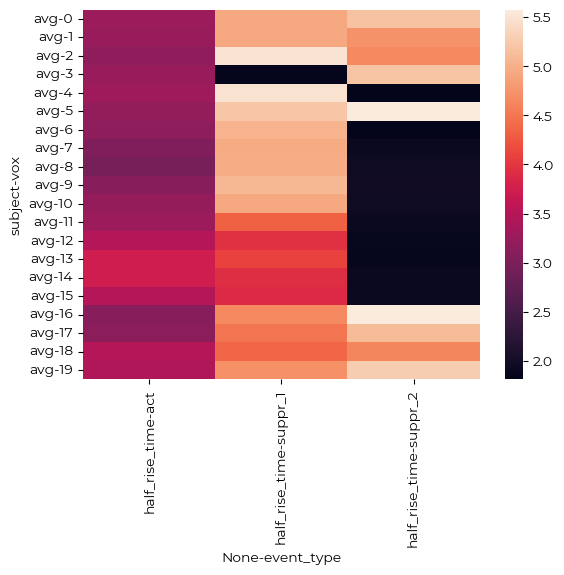

In [787]:
sns.heatmap(pd.DataFrame(comp_can.pars_condition["half_rise_time"]).unstack(["event_type"]))

In [ ]:
# parameter plot
incl_pars = {
    "magnitude": "%",
    "rise_slope": "a.u.",
    # # "fwhm": "seconds",
    # # "time_to_peak": "seconds",
    "onset_time": "seconds",
}

evs = utils.get_unique_ids(comp_can.avg_pars_subjects, id="event_type")
fig = plt.figure(figsize=(len(evs)*3,len(incl_pars)*3), constrained_layout=True)
sf = fig.subfigures(nrows=len(incl_pars))
for ix,(par,unit) in enumerate(incl_pars.items()):

    axs = sf[ix].subplots(ncols=len(evs), sharex=True)
    for iix,ev in enumerate(evs):
        df_par = utils.select_from_df(comp_can.avg_pars_subjects, expression=f"event_type = {ev}")
        par_avg = df_par.groupby(["vox"]).mean()
        tick_dict = hr.viz.make_wm_pial_ticks(par_avg)
        # pl = plotting.LazyCorr(
        #     data=df_par.groupby(["vox"]).mean(),
        #     x="vox",
        #     y=par,
        #     axs=axs[iix],
        #     reg_kwargs={
        #         "ci": None,
        #         "fit_reg": False
        #     },
        #     x_ticks=tick_dict["ticks"],
        #     x_ticklabels=tick_dict["labels"],
        #     error_kwargs={
        #         "yerr": df_par.groupby(["vox"]).sem()[par]
        #     },
        #     scatter_kwargs={
        #         "cbar": False,
        #         "cmap": "inferno_r"
        #     },
        #     color_by="vox",
        # )
        
        if ix+1 == len(incl_pars):
            x_t = tick_dict["ticks"]
            x_l = tick_dict["labels"]
        else:
            x_l = x_t = []

        if ix == 0:
            title = {
                "title": ["center","medium","large"][iix],
            }
        else:
            title = {
                "title": "something",
                "color": "#ffffff"
            }

        if iix == 0:
            # ppar = 
            y_lbl = f"{par.replace('_', ' ')} ({unit})"
        else:
            y_lbl = None

        grouper = df_par.groupby(["vox"])
        pl = plotting.LazyPlot(
            grouper.mean()[par].values.squeeze(),
            axs=axs[iix],
            line_width=3,
            error=grouper.sem()[par].values.squeeze(),
            markers=["o"],
            color=subj_obj.ev_colors[iix],
            x_ticks=x_t,
            x_ticklabels=x_l,
            title=title,
            y_label=y_lbl,
            y_dec=2
        )

        hr.viz.annotate_cortical_ribbon(
            pl.axs,
            pial_pos=(0.02,0.025),
            wm_pos=(0.8,0.025),
            fontsize=pl.font_size,
            fontweight="bold"
        )

    fig.supxlabel("depth", fontsize=pl.title_size)

    # if ix == 0:
    #     ax_inset = axs[0].inset_axes([0.88,0.8,0.02,0.3])
    #     cb = plotting.LazyColorbar(
    #         cmap="inferno",
    #         axs=ax_inset,
    #         cm_nr=2,
    #     )

    #     cb.axs.set_yticklabels(["wm","pial"])

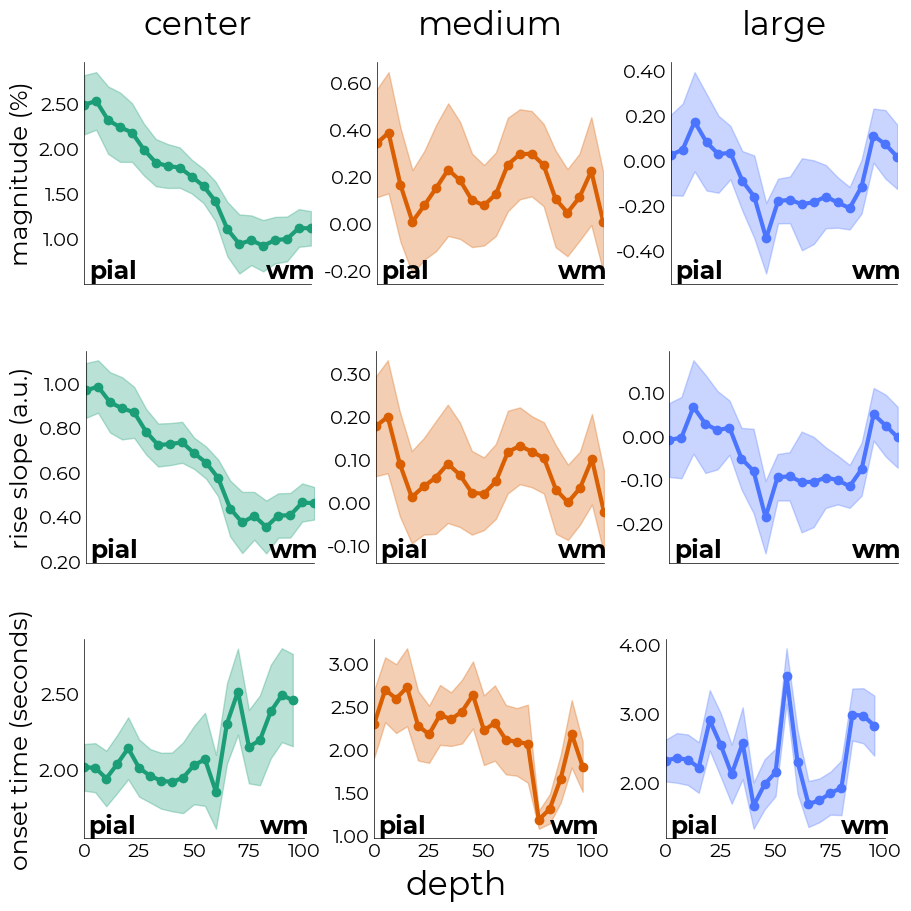

In [762]:
# parameter plot
incl_pars = {
    "magnitude": "%",
    "rise_slope": "a.u.",
    # # "fwhm": "seconds",
    # # "time_to_peak": "seconds",
    "onset_time": "seconds",
}

evs = utils.get_unique_ids(comp_can.avg_pars_subjects, id="event_type")
fig = plt.figure(figsize=(len(evs)*3,len(incl_pars)*3), constrained_layout=True)
sf = fig.subfigures(nrows=len(incl_pars))
for ix,(par,unit) in enumerate(incl_pars.items()):

    axs = sf[ix].subplots(ncols=len(evs), sharex=True)
    for iix,ev in enumerate(evs):
        df_par = utils.select_from_df(comp_can.avg_pars_subjects, expression=f"event_type = {ev}")
        par_avg = df_par.groupby(["vox"]).mean()
        tick_dict = hr.viz.make_wm_pial_ticks(par_avg)
        # pl = plotting.LazyCorr(
        #     data=df_par.groupby(["vox"]).mean(),
        #     x="vox",
        #     y=par,
        #     axs=axs[iix],
        #     reg_kwargs={
        #         "ci": None,
        #         "fit_reg": False
        #     },
        #     x_ticks=tick_dict["ticks"],
        #     x_ticklabels=tick_dict["labels"],
        #     error_kwargs={
        #         "yerr": df_par.groupby(["vox"]).sem()[par]
        #     },
        #     scatter_kwargs={
        #         "cbar": False,
        #         "cmap": "inferno_r"
        #     },
        #     color_by="vox",
        # )
        
        if ix+1 == len(incl_pars):
            x_t = tick_dict["ticks"]
            x_l = tick_dict["labels"]
        else:
            x_l = x_t = []

        if ix == 0:
            title = {
                "title": ["center","medium","large"][iix],
            }
        else:
            title = {
                "title": "something",
                "color": "#ffffff"
            }

        if iix == 0:
            # ppar = 
            y_lbl = f"{par.replace('_', ' ')} ({unit})"
        else:
            y_lbl = None

        grouper = df_par.groupby(["vox"])
        pl = plotting.LazyPlot(
            grouper.mean()[par].values.squeeze(),
            axs=axs[iix],
            line_width=3,
            error=grouper.sem()[par].values.squeeze(),
            markers=["o"],
            color=subj_obj.ev_colors[iix],
            x_ticks=x_t,
            x_ticklabels=x_l,
            title=title,
            y_label=y_lbl,
            y_dec=2
        )

        hr.viz.annotate_cortical_ribbon(
            pl.axs,
            pial_pos=(0.02,0.025),
            wm_pos=(0.8,0.025),
            fontsize=pl.font_size,
            fontweight="bold"
        )

    fig.supxlabel("depth", fontsize=pl.title_size)

    # if ix == 0:
    #     ax_inset = axs[0].inset_axes([0.88,0.8,0.02,0.3])
    #     cb = plotting.LazyColorbar(
    #         cmap="inferno",
    #         axs=ax_inset,
    #         cm_nr=2,
    #     )

    #     cb.axs.set_yticklabels(["wm","pial"])

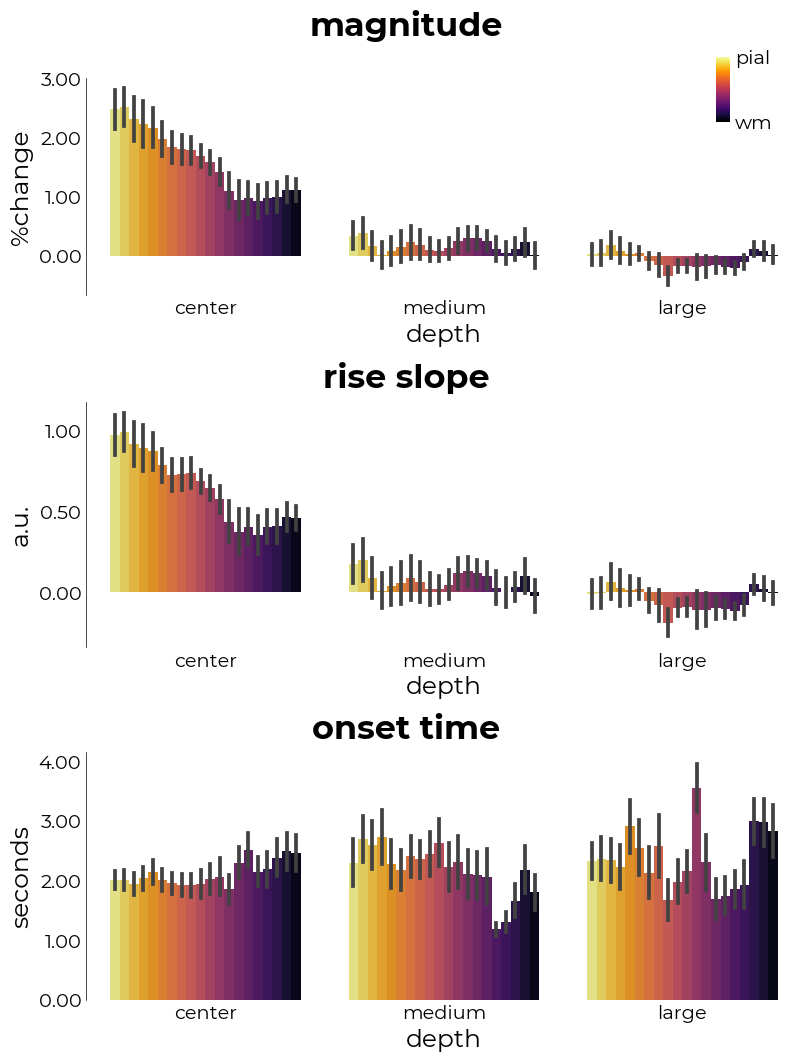

In [674]:
# parameter plot
incl_pars = {
    "magnitude": "%change",
    "rise_slope": "a.u.",
    # "fwhm": "seconds",
    # "time_to_peak": "seconds",
    "onset_time": "seconds",
}

fig = plt.figure(figsize=(8,len(incl_pars)*3.5), constrained_layout=True)
sf = fig.subfigures(nrows=len(incl_pars))
for ix,(par,unit) in enumerate(incl_pars.items()):
    axs = sf[ix].subplots()
    bar_plot = plotting.LazyBar(
        data=comp_can.avg_pars_subjects,
        x="event_type",
        y=par,
        add_labels=True,
        labels=["center","medium","large"],
        axs=axs,
        x_label="depth",
        y_label=unit,
        points_color="k",
        hue="vox",
        y_dec=2,
        cmap="inferno_r"
    ) 

    sf[ix].suptitle(
        par.replace("_"," "), 
        fontsize=bar_plot.title_size, 
        fontweight="bold"
    )

    if ix == 0:
        ax_inset = axs.inset_axes([0.88,0.8,0.02,0.3])
        cb = plotting.LazyColorbar(
            cmap="inferno",
            axs=ax_inset,
            cm_nr=2,
        )

        cb.axs.set_yticklabels(["wm","pial"])

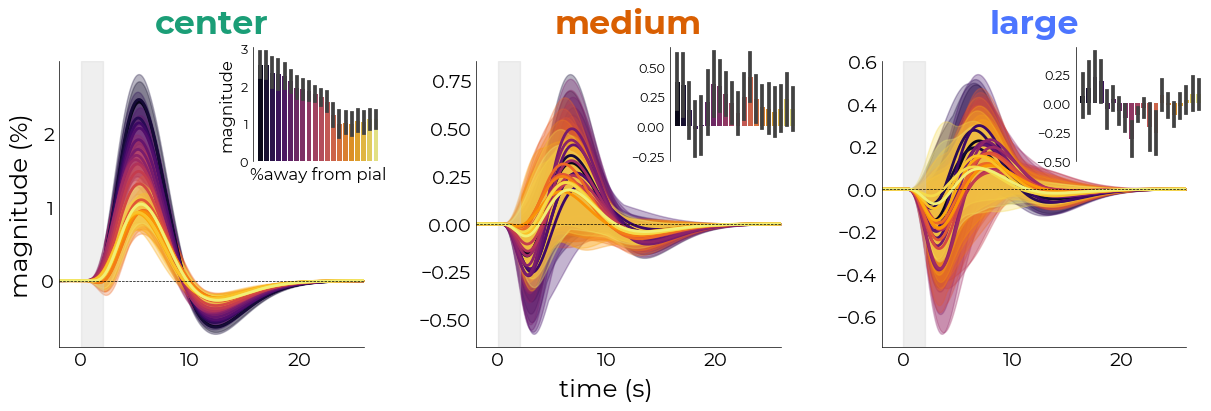

In [771]:
# dec_comp | profile plot
dec_comp = hr.viz.PlotDeconvProfiles(
    comp_can,
    inset_kwargs={
        # "fancy_denom": 3,
        "sns_offset": 3,
        # "add_points": True,
        "sns_ori": "v",
        "add_labels": False
    },
    ev_names=["center","medium","large"],
    ev_colors=subj_obj.get_colors(),
    bold_title=True,
    err="sem",
    inset_par="magnitude",
    force_int=True
)

In [327]:
# save | read

data_dir = opj(subj_obj.repo_dir, "data")
if not os.path.exists(data_dir):
    os.makedirs(data_dir, exist_ok=True)

fir_pkl = opj(data_dir, f"deconvolve_desc-can.pkl")
overwrite = False
save = True

if not os.path.exists(fir_pkl) or overwrite:
    if save:
        print(f"Writing to '{fir_pkl}'")
        with open(fir_pkl, 'wb') as handle:
            pickle.dump(comp_can, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    print(f"Reading from '{fir_pkl}'")
    with open(fir_pkl, 'rb') as handle:
        comp_can = pickle.load(handle)


In [770]:
# save parameters
comp_can.avg_pars_subjects.to_csv(opj(data_dir, f"deconvolve_desc-can_parameters.csv"))

In [769]:

import pingouin as pg
pg.rm_anova(
    utils.select_from_df(comp_can.avg_pars_subjects.reset_index(), expression=f"event_type = suppr_2"), 
    dv="onset_time", 
    within=["vox"], 
    subject="subject"
)

Source  ddof1  ddof2         F     p-unc       ng2       eps
0    vox     19    190  1.826779  0.022359  0.136622  0.339016

### Parameters from epochs

In [727]:
avg_epoch_run = hr.data.make_single_df(comp_excl, idx=["subject","event_type","run","epoch","t"]).groupby(["subject","event_type","t"]).mean()

dfs = []
for sub in include_subjs:
    
    evs = utils.get_unique_ids(avg_epoch_run, id="event_type")
    for ev in evs:
        tt = fitting.HRFMetrics(
            utils.multiselect_from_df(avg_epoch_run, expression=[f"subject = {sub}", f"event_type = {ev}"]),
            shift=None,
            TR=0.105
        ).return_metrics()
        
        tt["subject"], tt["event_type"] = sub,ev
        tt.set_index(["subject","event_type","vox"], inplace=True)
        dfs.append(tt)

dfs = pd.concat(dfs)
dfs

magnitude  magnitude_ix      fwhm  \
subject event_type vox                                      
001     act        0     3.136765            61  5.654259   
                   1     3.200889            61  5.693010   
                   2     3.123352            80  5.588417   
                   3     3.548124            71  5.168818   
                   4     3.284121            71  4.955280   
...                           ...           ...       ...   
022     suppr_2    15    0.416212           101  0.171931   
                   16    0.413827            14  5.383134   
                   17    0.664763            15  5.588504   
                   18    0.664763            15  5.588504   
                   19    0.413827            14  5.383134   

                                                                 fwhm_obj  \
subject event_type vox                                                      
001     act        0    <linescanning.fitting.FWHM object at 0x7faaba3...   
                   1    <linescanning.fitting.FWHM object at 0x7fae0d5...   
                   2    <linescanning.fitting.FWHM object at 0x7faabae...   
                   3    <linescanning.fitting.FWHM object at 0x7fae0cc...   
                   4    <linescanning.fitting.FWHM object at 0x7fae0d5...   
...                                                                   ...   
022     suppr_2    15   <linescanning.fitting.FWHM object at 0x7fae0bb...   
                   16   <linescanning.fitting.FWHM object at 0x7fae0bb...   
                   17   <linescanning.fitting.FWHM object at 0x7fae0bc...   
                   18   <linescanning.fitting.FWHM object at 0x7fae0bc...   
                   19   <linescanning.fitting.FWHM object at 0x7fae0bb...   

                        time_to_peak  half_rise_time  half_max  rise_slope  \
subject event_type vox                                                       
001     act        0        4.421053        3.212963  1.563239    1.640993   
                   1        4.421053        3.199124  1.595701    1.560775   
                   2        6.421053        3.236247  1.557620    1.565646   
                   3        5.473684        3.461886  1.772269    1.156861   
                   4        5.473684        3.485506  1.640526    0.823156   
...                              ...             ...       ...         ...   
022     suppr_2    15       8.631579       -1.952498  0.197679   -0.006299   
                   16      -0.526316        0.069414  0.206863   -0.093648   
                   17      -0.421053        0.072765  0.330341    0.098742   
                   18      -0.421053        0.072765  0.330341    0.098742   
                   19      -0.526316        0.069414  0.206863   -0.093648   

                       onset_time  positive_area  undershoot  \
subject event_type vox                                         
001     act        0     2.328403      16.041936    1.170722   
                   1     2.245708      15.810081    1.074540   
                   2     2.279018      16.248230    1.947684   
                   3     1.850641      16.951607    3.226164   
                   4      1.48474      14.980488    2.337946   
...                           ...            ...         ...   
022     suppr_2    15         NaN       0.489966    0.108599   
                   16         NaN       0.726017    0.001103   
                   17         NaN       1.124072    0.002563   
                   18         NaN       1.124072    0.002563   
                   19         NaN       0.726017    0.001103   

                        1st_deriv_magnitude  1st_deriv_time_to_peak  \
subject event_type vox                                                
001     act        0              -0.710419               -1.894737   
                   1               0.410625               -1.368421   
                   2              -0.363394               -1.894737   
                   3     

In [728]:
# tm1 = utils.select_from_df(
#     utils.multiselect_from_df(
#         avg_epoch_run,
#         expression=[
#             "subject = 002",
#             "event_type = suppr_2"
#         ]
#     ),
#     expression="ribbon",
#     indices=[3]
# )

# rf = tm1.values.squeeze()
# t_orig = utils.get_unique_ids(tm1, id="t")
# pl = plotting.LazyPlot(
#     rf,
#     xx=t_orig,
#     figsize=(5,5),
#     line_width=3,
#     color=["r","k"][0],
#     line_style=["solid","dashed"][0],
#     add_hline=0
# )

In [729]:
# mag = fitting.HRFMetrics._get_amplitude(
#         tm1, 
#         peak=4
#     )

# negative = False
# if mag["amplitude"]<0:
#     negative = True
#     ffunc = np.amin
# else:
#     ffunc = np.amax

# time_col = "t"
# time = np.array(utils.get_unique_ids(tm1, id=time_col))
# rf = tm1.values.squeeze()
# mag_ix = mag["t_ix"]
# idcs = sorted([utils.find_nearest(rf[:mag_ix], ffunc(rf)*i)[0] for i in window])
# t0 = time[idcs[0]]
# t1 = time[idcs[1]]

# print(idcs)

# df_for_slope = utils.select_from_df(
#     tm1,
#     expression=(
#         f"{time_col} >= {t0}",
#         "&",
#         f"{time_col} < {t1}"
#     )
# )

# df_for_slope

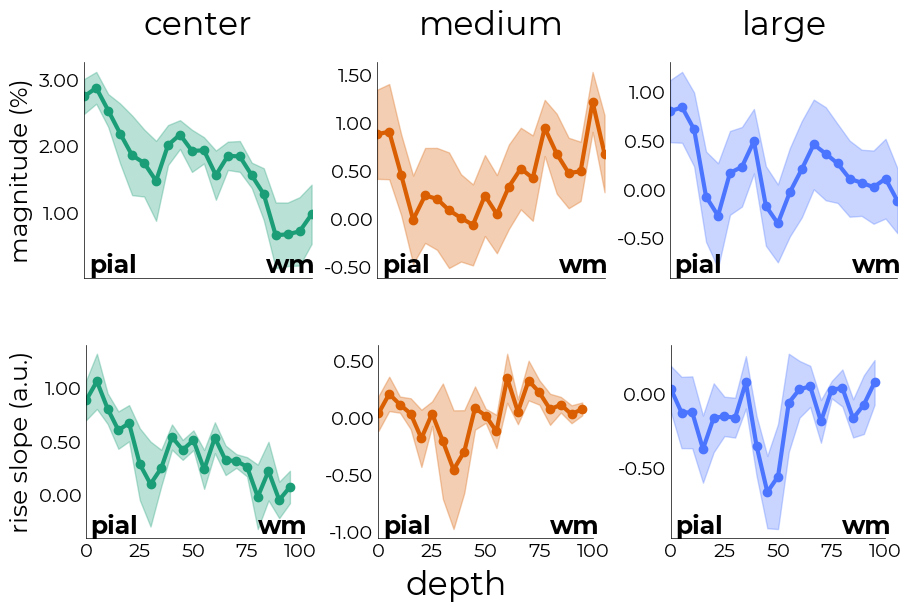

In [763]:
# parameter plot
incl_pars = {
    "magnitude": "%",
    "rise_slope": "a.u.",
    # # "fwhm": "seconds",
    # # "time_to_peak": "seconds",
    # "onset_time": "seconds",
}

evs = utils.get_unique_ids(dfs, id="event_type")
fig = plt.figure(figsize=(len(evs)*3,len(incl_pars)*3), constrained_layout=True)
sf = fig.subfigures(nrows=len(incl_pars))
for ix,(par,unit) in enumerate(incl_pars.items()):

    axs = sf[ix].subplots(ncols=len(evs), sharex=True)
    for iix,ev in enumerate(evs):
        df_par = utils.select_from_df(dfs, expression=f"event_type = {ev}")
        par_avg = df_par.groupby(["vox"]).mean()
        tick_dict = hr.viz.make_wm_pial_ticks(par_avg)
        
        if ix+1 == len(incl_pars):
            x_t = tick_dict["ticks"]
            x_l = tick_dict["labels"]
        else:
            x_l = x_t = []

        if ix == 0:
            title = {
                "title": ["center","medium","large"][iix],
            }
        else:
            title = {
                "title": "something",
                "color": "#ffffff"
            }

        if iix == 0:
            # ppar = 
            y_lbl = f"{par.replace('_', ' ')} ({unit})"
        else:
            y_lbl = None

        grouper = df_par.groupby(["vox"])
        pl = plotting.LazyPlot(
            grouper.mean()[par].values.squeeze(),
            axs=axs[iix],
            line_width=3,
            error=grouper.sem()[par].values.squeeze(),
            markers=["o"],
            color=subj_obj.ev_colors[iix],
            x_ticks=x_t,
            x_ticklabels=x_l,
            title=title,
            y_label=y_lbl,
            y_dec=2
        )

        hr.viz.annotate_cortical_ribbon(
            pl.axs,
            pial_pos=(0.02,0.025),
            wm_pos=(0.8,0.025),
            fontsize=pl.font_size,
            fontweight="bold"
        )

    fig.supxlabel("depth", fontsize=pl.title_size)

#### FIR

In [320]:
ff = hr.data.make_single_df(func_excl)
oo = hr.data.make_single_df(onset_excl, idx=["subject","run","event_type"])

comp_fit = fitting.NideconvFitter(
    ff,
    oo,
    basis_sets="fir",
    n_regressors="tr",
    TR=0.105,
    interval=[-2,26],
    verbose=True,
    conf_intercept=True,
)

comp_fit.timecourses_condition()
comp_fit.parameters_for_tc_subjects(shift=None)

Selected 'fir'-basis sets (with 267 regressors)
Adding event 'act' to model
Adding event 'suppr_1' to model
Adding event 'suppr_2' to model
Fitting with 'ols' minimization
Fitting completed
Fetching subject/condition-wise time courses from <nideconv.group_analysis.GroupResponseFitter object at 0x7faabb33d2e0>
Deriving parameters from <linescanning.fitting.NideconvFitter object at 0x7faac085c070> with 'HRFMetrics'


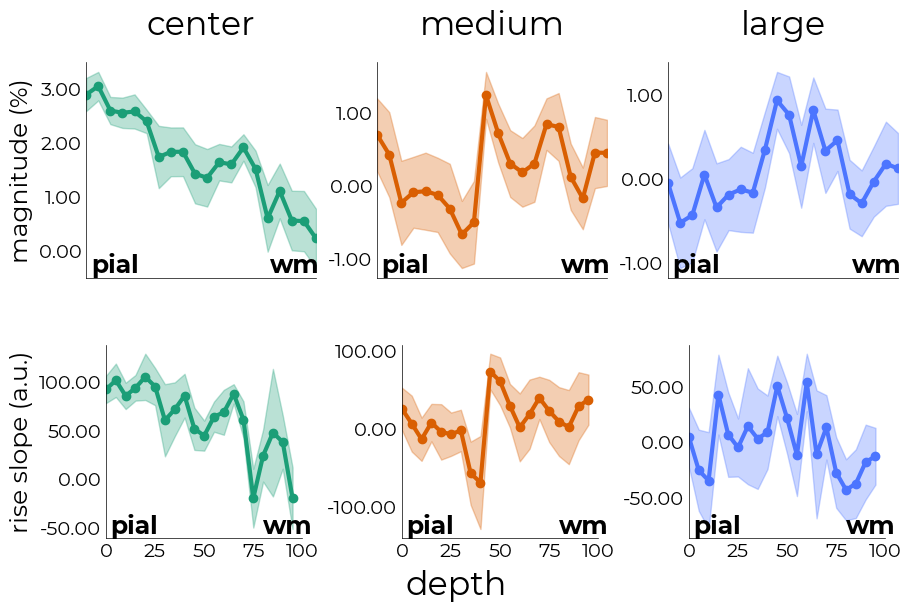

In [767]:
# parameter plot
incl_pars = {
    "magnitude": "%",
    "rise_slope": "a.u.",
    # # "fwhm": "seconds",
    # # "time_to_peak": "seconds",
    # "onset_time": "seconds",
}

evs = utils.get_unique_ids(comp_fit.avg_pars_subjects, id="event_type")
fig = plt.figure(figsize=(len(evs)*3,len(incl_pars)*3), constrained_layout=True)
sf = fig.subfigures(nrows=len(incl_pars))
for ix,(par,unit) in enumerate(incl_pars.items()):

    axs = sf[ix].subplots(ncols=len(evs), sharex=True)
    for iix,ev in enumerate(evs):
        df_par = utils.select_from_df(comp_fit.avg_pars_subjects, expression=f"event_type = {ev}")
        par_avg = df_par.groupby(["vox"]).mean()
        tick_dict = hr.viz.make_wm_pial_ticks(par_avg)
        
        if ix+1 == len(incl_pars):
            x_t = tick_dict["ticks"]
            x_l = tick_dict["labels"]
        else:
            x_l = x_t = []

        if ix == 0:
            title = {
                "title": ["center","medium","large"][iix],
            }
        else:
            title = {
                "title": "something",
                "color": "#ffffff"
            }

        if iix == 0:
            # ppar = 
            y_lbl = f"{par.replace('_', ' ')} ({unit})"
        else:
            y_lbl = None

        grouper = df_par.groupby(["vox"])
        pl = plotting.LazyPlot(
            grouper.mean()[par].values.squeeze(),
            axs=axs[iix],
            line_width=3,
            error=grouper.sem()[par].values.squeeze(),
            markers=["o"],
            color=subj_obj.ev_colors[iix],
            x_ticks=x_t,
            x_ticklabels=x_l,
            title=title,
            y_label=y_lbl,
            y_dec=2
        )

        hr.viz.annotate_cortical_ribbon(
            pl.axs,
            pial_pos=(0.02,0.025),
            wm_pos=(0.8,0.025),
            fontsize=pl.font_size,
            fontweight="bold"
        )

    fig.supxlabel("depth", fontsize=pl.title_size)

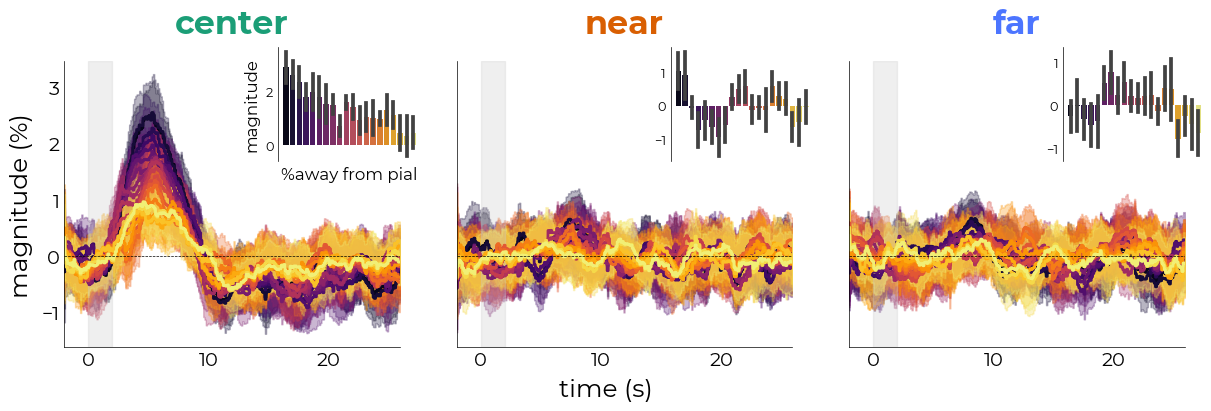

In [322]:
%matplotlib inline
dec_comp = hr.viz.PlotDeconvProfiles(
    comp_fit,
    inset_kwargs={
        # "fancy_denom": 3,
        "sns_offset": 3,
        # "add_points": True,
        "sns_ori": "v",
        "add_labels": False
    },
    ev_names=["center","near","far"],
    ev_colors=subj_obj.get_colors(),
    bold_title=True,
    err="sem",
    inset_par="magnitude",
    force_int=True
)

# hr.viz._save_figure(
#     dec_comp.fig, 
#     fname="group_desc-depth_deconv",
#     overwrite=True
# )

In [328]:
# save | read

data_dir = opj(subj_obj.repo_dir, "data")
if not os.path.exists(data_dir):
    os.makedirs(data_dir, exist_ok=True)

fir_pkl = opj(data_dir, f"deconvolve_desc-fir.pkl")
overwrite = False
save = True

if not os.path.exists(fir_pkl) or overwrite:
    if save:
        print(f"Writing to '{fir_pkl}'")
        with open(fir_pkl, 'wb') as handle:
            pickle.dump(comp_fit, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    print(f"Reading from '{fir_pkl}'")
    with open(fir_pkl, 'rb') as handle:
        comp_fit = pickle.load(handle)

Writing to '/data1/projects/MicroFunc/Jurjen/programs/project_repos/holeresponse/data/camel_deriv_desc-fir.pkl'
